In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, entropy
import os

In [25]:
# Part 1: Load Combined Detections Data
# 'birdnet_classification.csv' file should contain birdnet prediction data.
# results_df should have the combined data of all the spots.
OUTPUTS = [r"E:\processed_data\acoustic_biodiversity\analysis\audio_raw_spot_1_original_spot_20072025-29072025_2R4W_birdnet_classification.csv", r"E:\processed_data\acoustic_biodiversity\analysis\audio_raw_spot_2_peacock_spot_20072025-03082025_2R4W_birdnet_classification.csv", r"E:\processed_data\acoustic_biodiversity\analysis\audio_raw_spot_3_investigation_spot_20072025-03082025_2R4W_birdnet_classification.csv" , r"E:\processed_data\acoustic_biodiversity\analysis\audio_raw_spot_4_yoga_spot_20072025-03082025_2R4W_birdnet_classification.csv"]
results_df = pd.DataFrame()
for i in OUTPUTS:
    try:
        df = pd.read_csv(i)
        results_df = pd.concat([results_df, df], ignore_index=True)
    except FileNotFoundError:
        print(f"File {i} not found. Skipping...")

results_df['filename'] = results_df['filename'].str.replace("STOP", "SPOT", regex=False)

In [26]:
# Part 2: Essential Preprocessing - Add Spot and Date Information
# This step extracts location ('Spot') and time ('Date') from the filenames,
# enabling all subsequent spatial and temporal analyses.

results_df['Spot'] = results_df['filename'].str.extract(r'(SPOT\d+)', expand=False).str.lower().str.replace('spot', 'spot_')


date_info = results_df['filename'].str.extract(r'_(\d{8})_')
results_df['Date'] = pd.to_datetime(date_info[0], format='%Y%m%d')

results_df.dropna(subset=['Spot', 'Date'], inplace=True)

print("Preprocessing complete. 'Spot' and 'Date' columns added.")
print(f"Spots found: {sorted(results_df['Spot'].unique())}")
results_df.head()

common_name        scientific_name  start_time  end_time  \
0          Common Tailorbird    Orthotomus sutorius         0.0       3.0   
1             Jungle Babbler          Argya striata         3.0       6.0   
2             Jungle Babbler          Argya striata         9.0      12.0   
3             Jungle Babbler          Argya striata        12.0      15.0   
4             Indian Peafowl         Pavo cristatus         0.0       3.0   
...                      ...                    ...         ...       ...   
193712      Himalayan Bulbul  Pycnonotus leucogenys        78.0      81.0   
193713  Red-whiskered Bulbul     Pycnonotus jocosus        87.0      90.0   
193714        Indian Peafowl         Pavo cristatus        93.0      96.0   
193715        Indian Peafowl         Pavo cristatus        99.0     102.0   
193716        Indian Peafowl         Pavo cristatus       102.0     105.0   

        confidence                                    label  \
0         0.122334    Orthotomus sutorius_Common Tailorbird   
1         0.369348             Argya striata_Jungle Babbler   
2         0.379663             Argya striata_Jungle Babbler   
3         0.407963             Argya striata_Jungle Babbler   
4         0.106279            Pavo cristatus_Indian Peafowl   
...            ...                                      ...   
193712    0.248585   Pycnonotus leucogenys_Himalayan Bulbul   
193713    0.103092  Pycnonotus jocosus_Red-whiskered Bulbul   
193714    0.166298            Pavo cristatus_Indian Peafowl   
193715    0.961858            Pavo cristatus_Indian Peafowl   
193716    0.825198            Pavo cristatus_Indian Peafowl   

                                filename  year  month  day  hour  minute  
0         04213SPOT1_20250720_074253.wav  2025      7   20     7      42  
1         04213SPOT1_20250720_074253.wav  2025      7   20     7      42  
2         04213SPOT1_20250720_074253.wav  2025      7   20     7      42  
3         04213SPOT1_20250720_074253.wav  2025      7   20     7      42  
4         04213SPOT1_20250720_074800.wav  2025      7   20     7      48  
...                                  ...   ...    ...  ...   ...     ...  
193712  076YOGASPOT4_20250803_074400.wav  2025      8    3     7      44  
193713  076YOGASPOT4_20250803_074400.wav  2025      8    3     7      44  
193714  076YOGASPOT4_20250803_074400.wav  2025      8    3     7      44  
193715  076YOGASPOT4_20250803_074400.wav  2025      8    3     7      44  
193716  076YOGASPOT4_20250803_074400.wav  2025      8    3     7      44  

[193717 rows x 12 columns]

In [2]:
TEST = r"E:\processed_data\acoustic_biodiversity\analysis\audio_raw_spot_1_original_spot_20072025-29072025_2R4W_birdnet_classification.csv"
test_df = pd.read_csv(TEST)
test_df.head()

common_name      scientific_name  start_time  end_time  confidence  \
0  Common Tailorbird  Orthotomus sutorius         0.0       3.0    0.122334   
1     Jungle Babbler        Argya striata         3.0       6.0    0.369348   
2     Jungle Babbler        Argya striata         9.0      12.0    0.379663   
3     Jungle Babbler        Argya striata        12.0      15.0    0.407963   
4     Indian Peafowl       Pavo cristatus         0.0       3.0    0.106279   

                                   label                        filename  \
0  Orthotomus sutorius_Common Tailorbird  04213SPOT1_20250720_074253.wav   
1           Argya striata_Jungle Babbler  04213SPOT1_20250720_074253.wav   
2           Argya striata_Jungle Babbler  04213SPOT1_20250720_074253.wav   
3           Argya striata_Jungle Babbler  04213SPOT1_20250720_074253.wav   
4          Pavo cristatus_Indian Peafowl  04213SPOT1_20250720_074800.wav   

   year  month  day  hour  minute  
0  2025      7   20     7      42  
1  2025      7   20     7      42  
2  2025      7   20     7      42  
3  2025      7   20     7      42  
4  2025      7   20     7      48

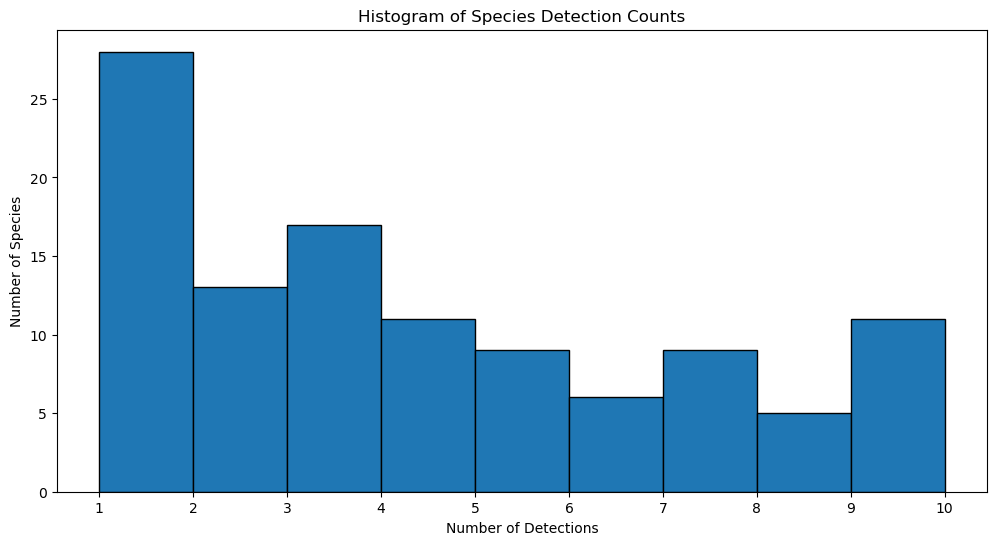

In [35]:
counts = results_df['common_name'].value_counts()
filtered_counts = counts[counts < 10]
plt.figure(figsize=(12, 6))
plt.hist(filtered_counts, bins=range(1,11), edgecolor='black')
plt.xlabel('Number of Detections')
plt.ylabel('Number of Species')
plt.title('Histogram of Species Detection Counts')
plt.xticks(range(1, 11))
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# --- 2. Calculate counts for each confidence level ---
results_df_filtered = results_df[results_df['confidence'] >= 0.3].copy()

def assign_confidence_category(confidence):
    if confidence >= 0.5:
        return 'Confidence >= 0.5'
    elif confidence >= 0.4:
        return '0.4 <= Confidence < 0.5'
    else: # confidence >= 0.3
        return '0.3 <= Confidence < 0.4'

results_df_filtered['conf_category'] = results_df_filtered['confidence'].apply(assign_confidence_category)

# --- 3. Prepare data for plotting ---
plot_data = results_df_filtered.pivot_table(index='common_name', columns='conf_category', aggfunc='size', fill_value=0)

for category in ['Confidence >= 0.5', '0.4 <= Confidence < 0.5', '0.3 <= Confidence < 0.4']:
    if category not in plot_data.columns:
        plot_data[category] = 0

plot_data = plot_data[['Confidence >= 0.5', '0.4 <= Confidence < 0.5', '0.3 <= Confidence < 0.4']]
plot_data['total_detections'] = plot_data.sum(axis=1)
plot_data = plot_data.sort_values(by='total_detections', ascending=False).drop(columns=['total_detections'])

# --- 4. Generate Multiple Plots ---

# Set how many species you want to display on each graph
species_per_plot = 50
total_species = len(plot_data)
num_plots = math.ceil(total_species / species_per_plot)

print(f"\nTotal species to plot: {total_species}")
print(f"Generating {num_plots} separate plots with up to {species_per_plot} species each.")

for i in range(num_plots):
    # Determine the slice of data for the current plot
    start_index = i * species_per_plot
    end_index = start_index + species_per_plot
    data_slice = plot_data.iloc[start_index:end_index]

    # Create the plot
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(16, 10))

    data_slice.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=sns.color_palette("viridis", 3)
    )

    # Customize the plot
    plot_number = i + 1
    ax.set_title(f'Cumulative Bird Detections (Part {plot_number} of {num_plots})', fontsize=20, pad=20)
    ax.set_xlabel('Bird Species', fontsize=14, labelpad=15)
    ax.set_ylabel('Number of Detections', fontsize=14, labelpad=15)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    ax.legend(title='Confidence Threshold', fontsize=12, title_fontsize=14)
    plt.tight_layout()

    # Save the figure to a file
    output_filename = f'bird_detections_plot_{plot_number}.png'
    plt.savefig(output_filename)
    plt.close(fig) # Close the figure to free up memory
    print(f"Saved chart to {output_filename}")
    plt.show()


Total species to plot: 215
Generating 5 separate plots with up to 50 species each.
Saved chart to bird_detections_plot_1.png
Saved chart to bird_detections_plot_2.png
Saved chart to bird_detections_plot_3.png
Saved chart to bird_detections_plot_4.png
Saved chart to bird_detections_plot_5.png


Filtering data, based on confidence and frequency

In [28]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# --- 2. Calculate counts for each confidence level ---
results_df_filtered = results_df[results_df['confidence'] >= 0.3].copy()

def assign_confidence_category(confidence):
    if confidence >= 0.5:
        return 'Confidence >= 0.5'
    elif confidence >= 0.4:
        return '0.4 <= Confidence < 0.5'
    else: # confidence >= 0.3
        return '0.3 <= Confidence < 0.4'
    # return ""

results_df_filtered['conf_category'] = results_df_filtered['confidence'].apply(assign_confidence_category)

# --- 3. Prepare data for plotting ---
plot_data = results_df_filtered.pivot_table(index='common_name', columns='conf_category', aggfunc='size', fill_value=0)

for category in ['Confidence >= 0.5', '0.4 <= Confidence < 0.5', '0.3 <= Confidence < 0.4']:
    if category not in plot_data.columns:
        plot_data[category] = 0

plot_data = plot_data[['Confidence >= 0.5', '0.4 <= Confidence < 0.5', '0.3 <= Confidence < 0.4']]
plot_data['total_detections'] = plot_data.sum(axis=1)
plot_data = plot_data.sort_values(by='total_detections', ascending=False).drop(columns=['total_detections'])

# --- 4. Generate Multiple Plots ---

# Set how many species you want to display on each graph
species_per_plot = 50
total_species = len(plot_data)
num_plots = math.ceil(total_species / species_per_plot)

print(f"\nTotal species to plot: {total_species}")
print(f"Generating {num_plots} separate plots with up to {species_per_plot} species each.")

for i in range(num_plots):
    # Determine the slice of data for the current plot
    start_index = i * species_per_plot
    end_index = start_index + species_per_plot
    data_slice = plot_data.iloc[start_index:end_index]

    # Create the plot
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(16, 10))

    data_slice.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=sns.color_palette("viridis", 3)
    )

    # Customize the plot
    plot_number = i + 1
    ax.set_title(f'Cumulative Bird Detections (Part {plot_number} of {num_plots})', fontsize=20, pad=20)
    ax.set_xlabel('Bird Species', fontsize=14, labelpad=15)
    ax.set_ylabel('Number of Detections', fontsize=14, labelpad=15)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    ax.legend(title='Confidence Threshold', fontsize=12, title_fontsize=14)
    plt.tight_layout()

    # Save the figure to a file
    output_filename = f'bird_detections_all_plot_{plot_number}.png'
    plt.savefig(output_filename)
    plt.close(fig) # Close the figure to free up memory
    print(f"Saved chart to {output_filename}")
    plt.show()


Total species to plot: 215
Generating 5 separate plots with up to 50 species each.
Saved chart to bird_detections_all_plot_1.png
Saved chart to bird_detections_all_plot_2.png
Saved chart to bird_detections_all_plot_3.png
Saved chart to bird_detections_all_plot_4.png
Saved chart to bird_detections_all_plot_5.png


In [29]:

# 1. Calculate the total bar height for each species from the full dataset
# The 'plot_data' DataFrame should already exist from the code above.
plot_data_with_totals = plot_data.copy()
plot_data_with_totals['total_bar_height'] = plot_data_with_totals.sum(axis=1)

# 2. Filter for species where the total bar height is >= 10
summary_plot_data = plot_data_with_totals[plot_data_with_totals['total_bar_height'] >= 10]

# 3. Sort the results and remove the helper column before plotting
summary_plot_data = summary_plot_data.sort_values(by='total_bar_height', ascending=False)
summary_plot_data = summary_plot_data.drop(columns=['total_bar_height'])

In [30]:
frequent_bird_names = summary_plot_data.index.tolist()

df_frequent_only = results_df[results_df['common_name'].isin(frequent_bird_names)].copy()
results_df = df_frequent_only.copy()

### Part 3: Behavioral Stickiness Analyses
This section quantifies the predictability of species behavior. 
- **Temporal Stickiness:** How consistent is a species' daily activity schedule?
- **Spatial Stickiness:** How consistently does a species prefer the same locations?

Calculating Temporal Stickiness...
Calculating Average Daily Calls for top species...
Generating plots...


C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\2362455229.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Temporal_Stickiness', y='label', data=top_temporal, palette='plasma', ax=ax1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\2362455229.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Avg_Calls_Per_Day", y="label", data=avg_calls_per_day, palette="magma", ax=ax2)


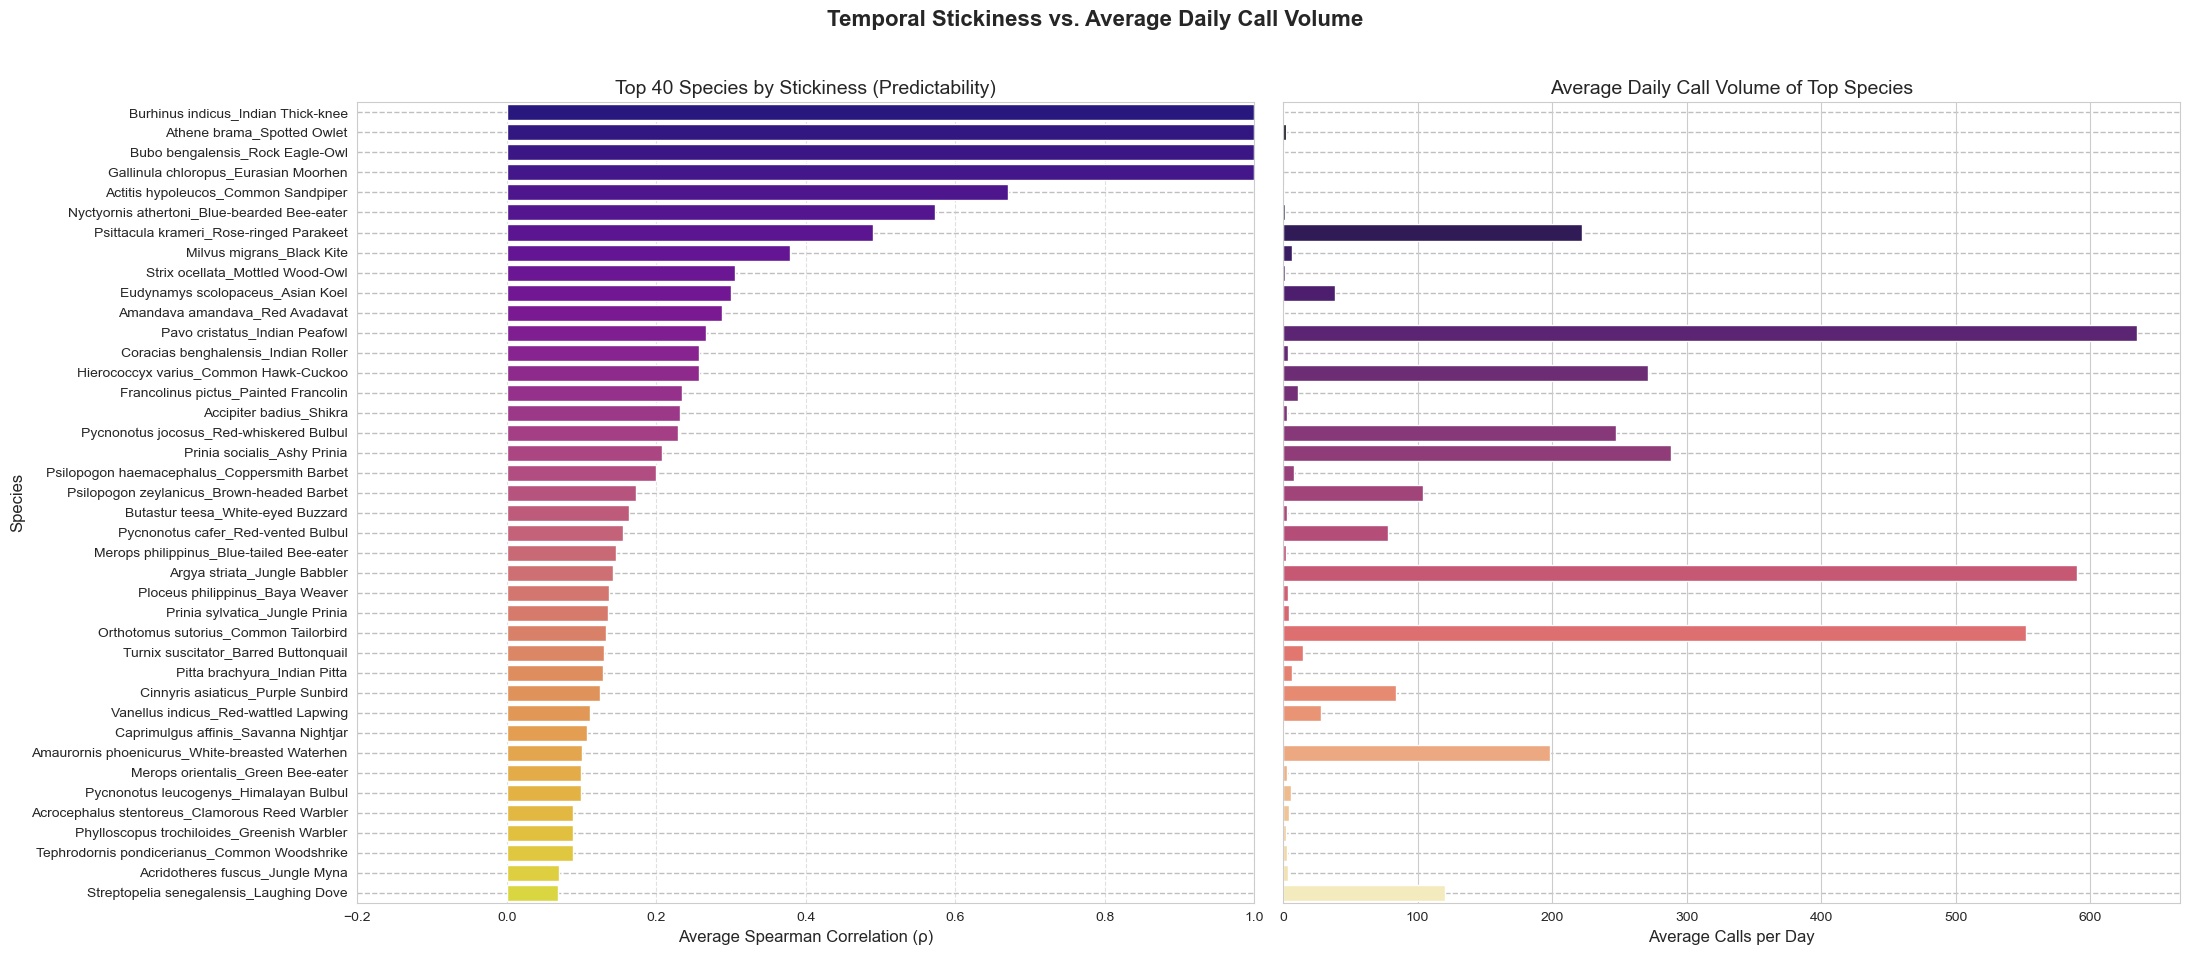

In [39]:
# --- Temporal Stickiness Analysis ---
print("Calculating Temporal Stickiness...")

date_info = results_df['filename'].str.extract(r'_(\d{8})_')
results_df['Date'] = pd.to_datetime(date_info[0], format='%Y%m%d')
results_df['Spot'] = results_df['filename'].str.extract(r'(SPOT\d+)', expand=False).str.lower().str.replace('spot', 'spot_')
results_df.dropna(subset=['Spot', 'Date'], inplace=True)

ACTIVITY_HOURS = range(5, 20)
# activity_df = results_df[(results_df['confidence'] >= 0.5) & (results_df['hour'].isin(ACTIVITY_HOURS))].copy()
activity_df = results_df[(results_df['confidence'] >= 0.3) & (results_df['hour'].isin(ACTIVITY_HOURS))].copy()

species_list = activity_df['label'].unique()
spot_list = activity_df['Spot'].unique()
date_list = sorted(activity_df['Date'].unique())
num_days = activity_df['Date'].nunique() # Calculate the number of unique days for averaging

temporal_stickiness = {}

for species in species_list:
    species_spot_correlations = []
    for spot in spot_list:
        spot_day_correlations = []
        for i in range(len(date_list) - 1):
            day_k = date_list[i]
            day_k_plus_1 = date_list[i+1]
            series_k = activity_df[(activity_df['label'] == species) & (activity_df['Spot'] == spot) & (activity_df['Date'] == day_k)]['hour'].value_counts().reindex(ACTIVITY_HOURS, fill_value=0)
            series_k_plus_1 = activity_df[(activity_df['label'] == species) & (activity_df['Spot'] == spot) & (activity_df['Date'] == day_k_plus_1)]['hour'].value_counts().reindex(ACTIVITY_HOURS, fill_value=0)
            if series_k.sum() > 0 and series_k_plus_1.sum() > 0:
                corr, _ = spearmanr(series_k, series_k_plus_1)
                spot_day_correlations.append(corr)
        if spot_day_correlations:
            species_spot_correlations.append(np.mean(spot_day_correlations))
    if species_spot_correlations:
        temporal_stickiness[species] = np.mean(species_spot_correlations)

temporal_stickiness_df = pd.DataFrame(list(temporal_stickiness.items()), columns=['label', 'Temporal_Stickiness'])
top_temporal = temporal_stickiness_df.sort_values(by='Temporal_Stickiness', ascending=False).head(40)


# --- 2. Calculate Average Daily Calls for the Top Species ---
print("Calculating Average Daily Calls for top species...")
# Filter the main dataframe to only the species in the top_temporal chart
top_species_calls_df = activity_df[activity_df["label"].isin(top_temporal["label"])]

# Calculate the average by counting total calls and dividing by the number of days
avg_calls_per_day = top_species_calls_df.groupby("label").size().reset_index(name="total_calls")
avg_calls_per_day["Avg_Calls_Per_Day"] = avg_calls_per_day["total_calls"] / num_days

# **Important**: Reorder the data to match the stickiness chart's order
avg_calls_per_day = avg_calls_per_day.set_index("label").reindex(top_temporal["label"]).fillna(0).reset_index()


# --- 3. Create Side-by-Side Visualization ---
print("Generating plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle('Temporal Stickiness vs. Average Daily Call Volume', fontsize=16, fontweight='bold')

# Plot 1: Temporal Stickiness
sns.barplot(x='Temporal_Stickiness', y='label', data=top_temporal, palette='plasma', ax=ax1)
ax1.set_title('Top 40 Species by Stickiness (Predictability)', fontsize=14)
ax1.set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
ax1.set_ylabel("Species", fontsize=12)
ax1.set_xlim(-0.2, 1.0)
ax1.grid(axis='x', linestyle='--', alpha=0.6)

# Plot 2: Average Daily Calls
sns.barplot(x="Avg_Calls_Per_Day", y="label", data=avg_calls_per_day, palette="magma", ax=ax2)
ax2.set_title('Average Daily Call Volume of Top Species', fontsize=14)
ax2.set_xlabel("Average Calls per Day", fontsize=12)
ax2.set_ylabel("") # Hide the y-label to avoid repetition
ax2.tick_params(axis='y', which='both', left=False, labelleft=False) # Hide y-axis ticks and labels

# Add connecting lines to make comparison easier
for i in range(len(top_temporal)):
    for ax in [ax1, ax2]:
        ax.axhline(y=i, color='grey', linestyle='--', alpha=0.5, linewidth=1, zorder=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Calculating Temporal-Spatial Stickiness...
Starting combined analysis for all spots...


C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Temporal_Stickiness', y='label', data=top_temporal, palette='plasma', ax=ax1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Avg_Calls_Per_Day", y="label", data=avg_calls_per_day, palette="magma", ax=ax2)


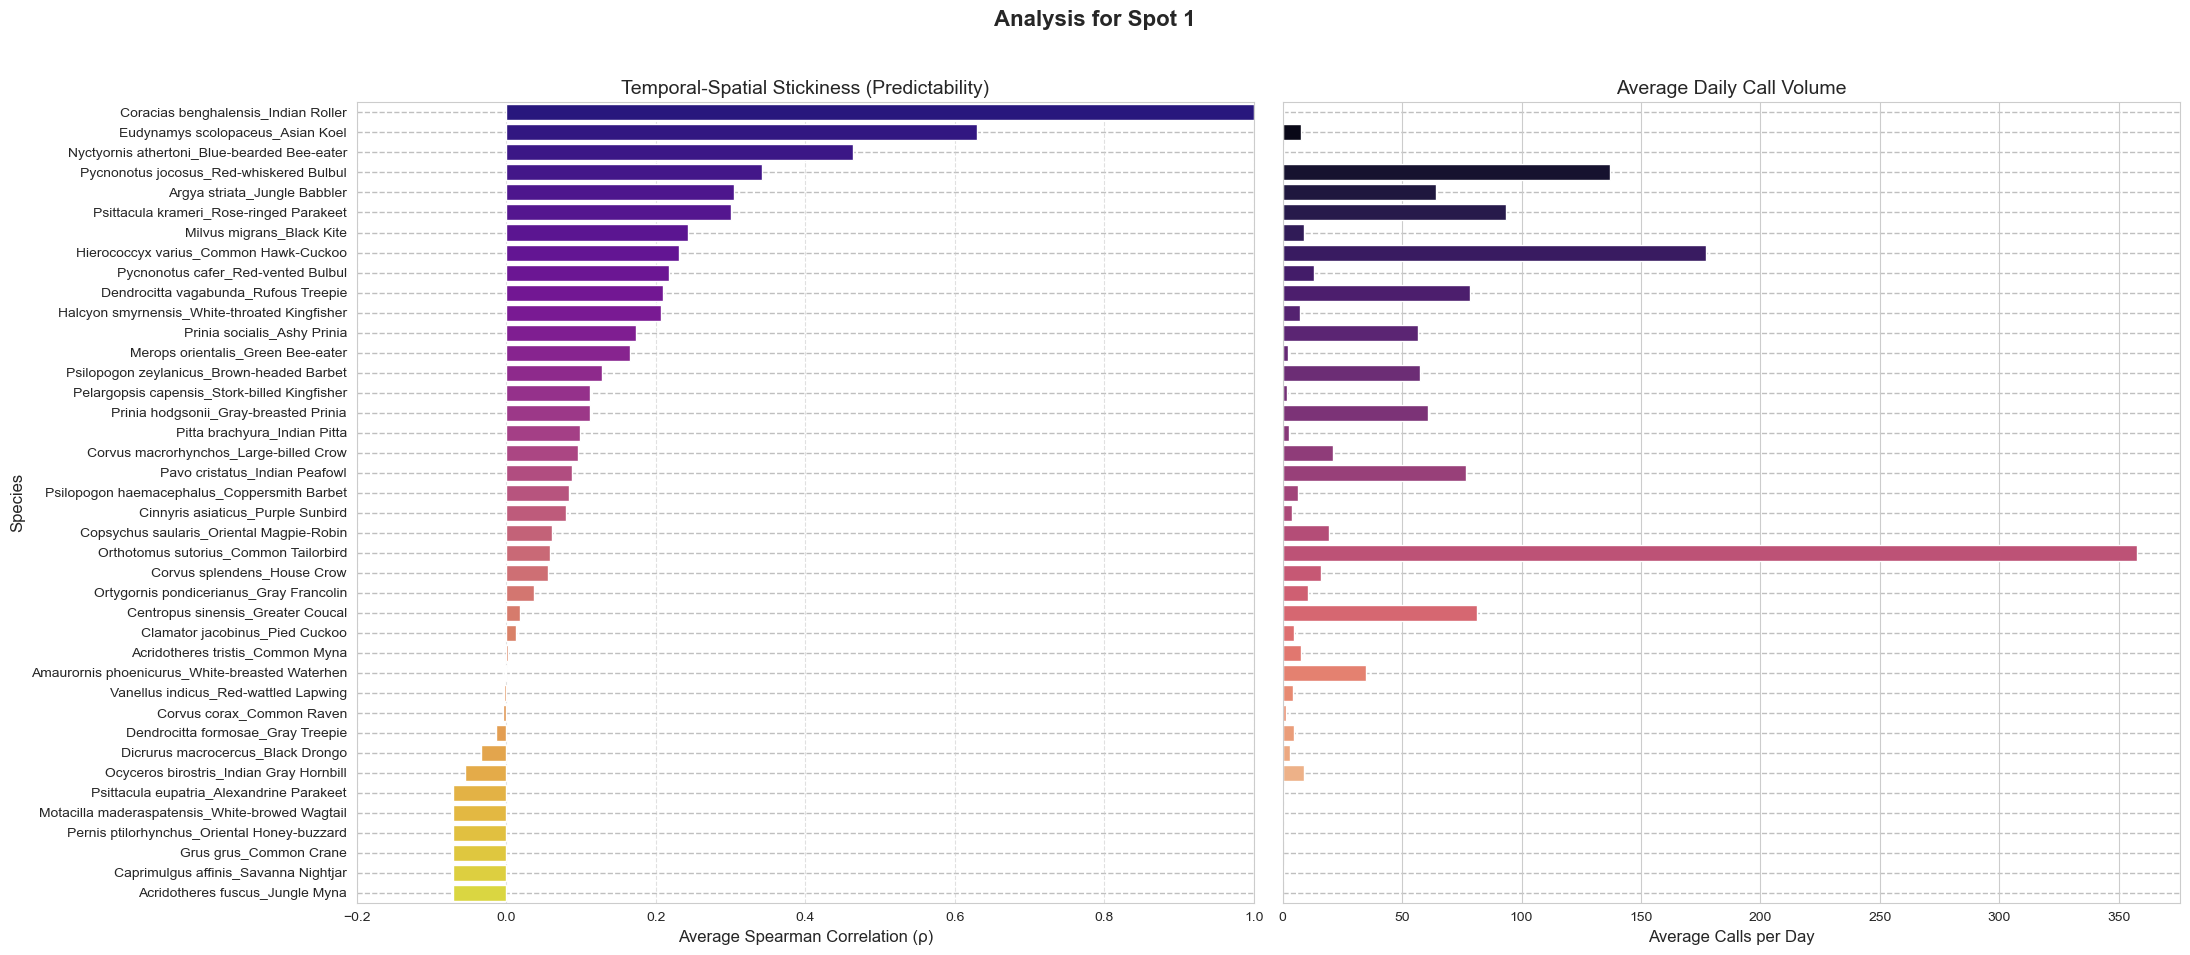

C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Temporal_Stickiness', y='label', data=top_temporal, palette='plasma', ax=ax1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Avg_Calls_Per_Day", y="label", data=avg_calls_per_day, palette="magma", ax=ax2)


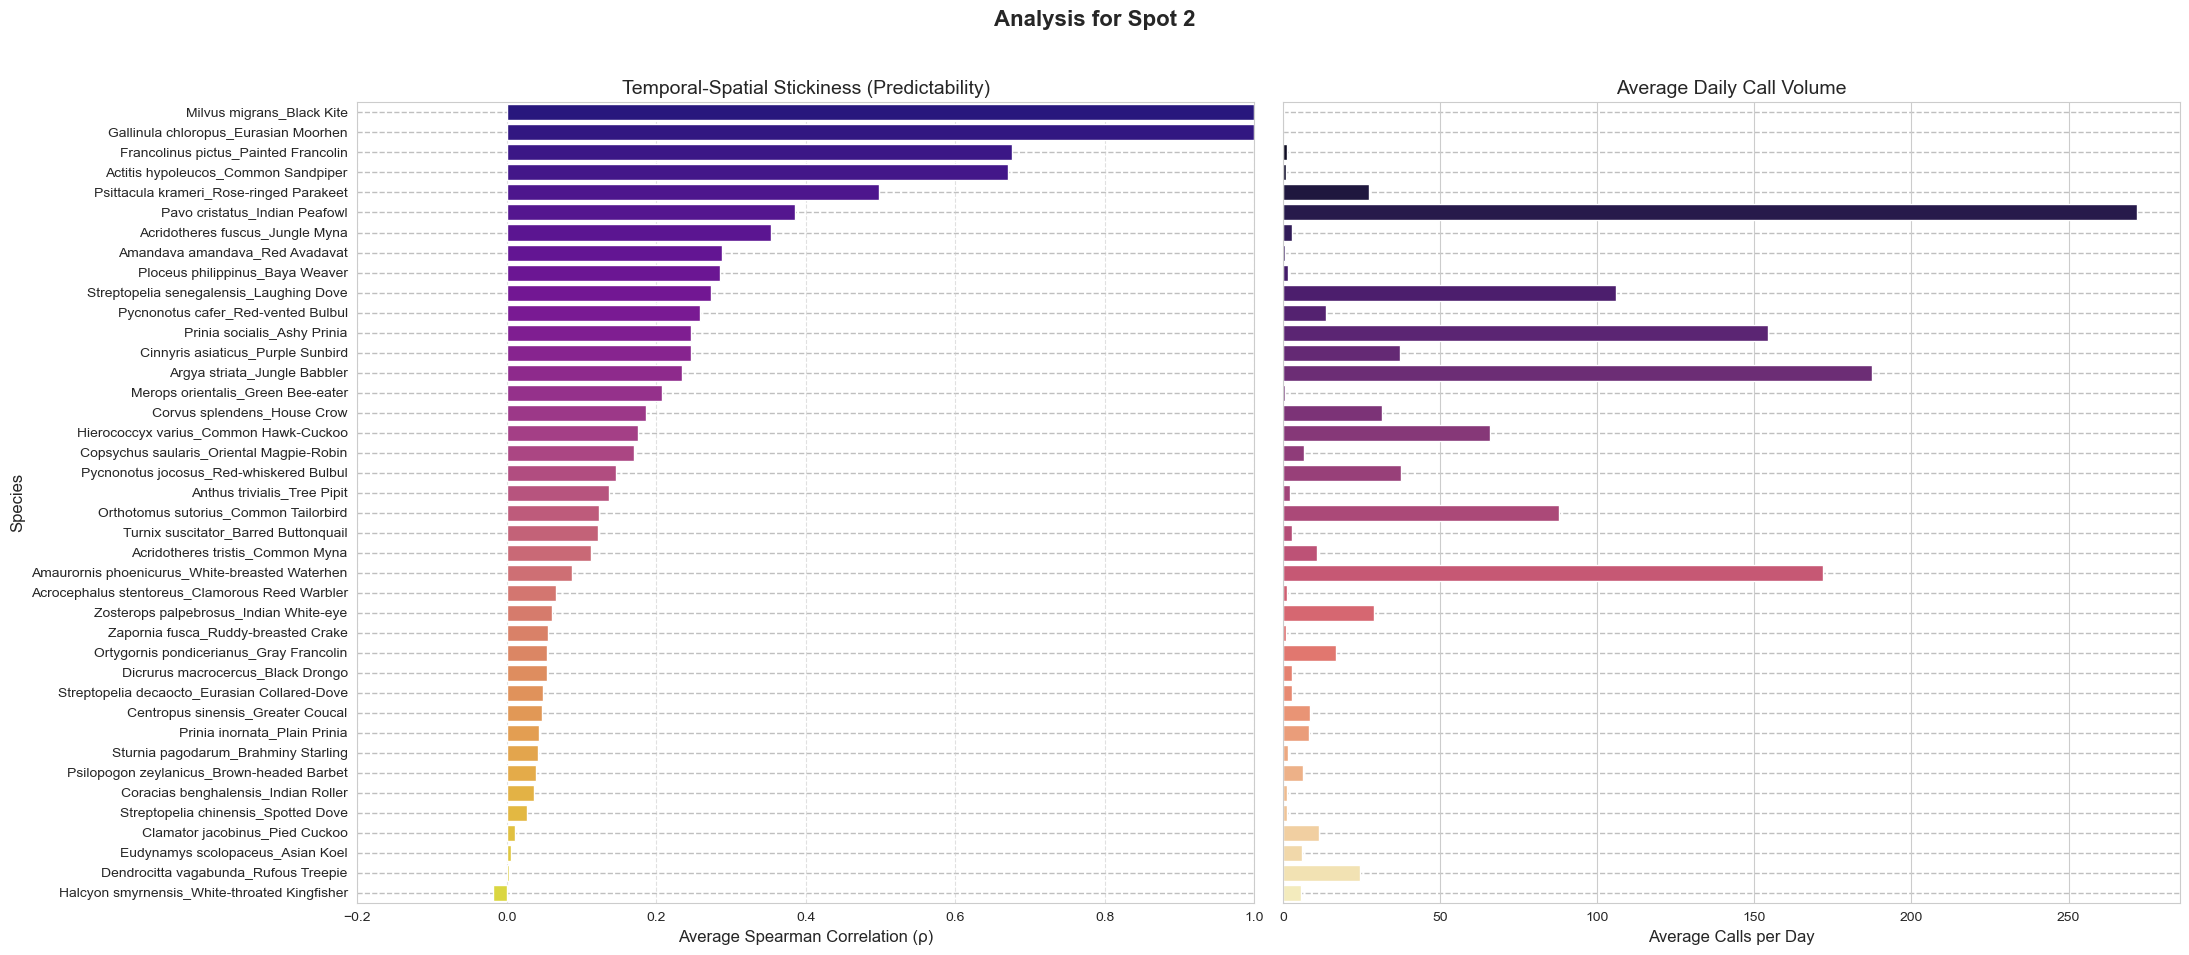

C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Temporal_Stickiness', y='label', data=top_temporal, palette='plasma', ax=ax1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Avg_Calls_Per_Day", y="label", data=avg_calls_per_day, palette="magma", ax=ax2)


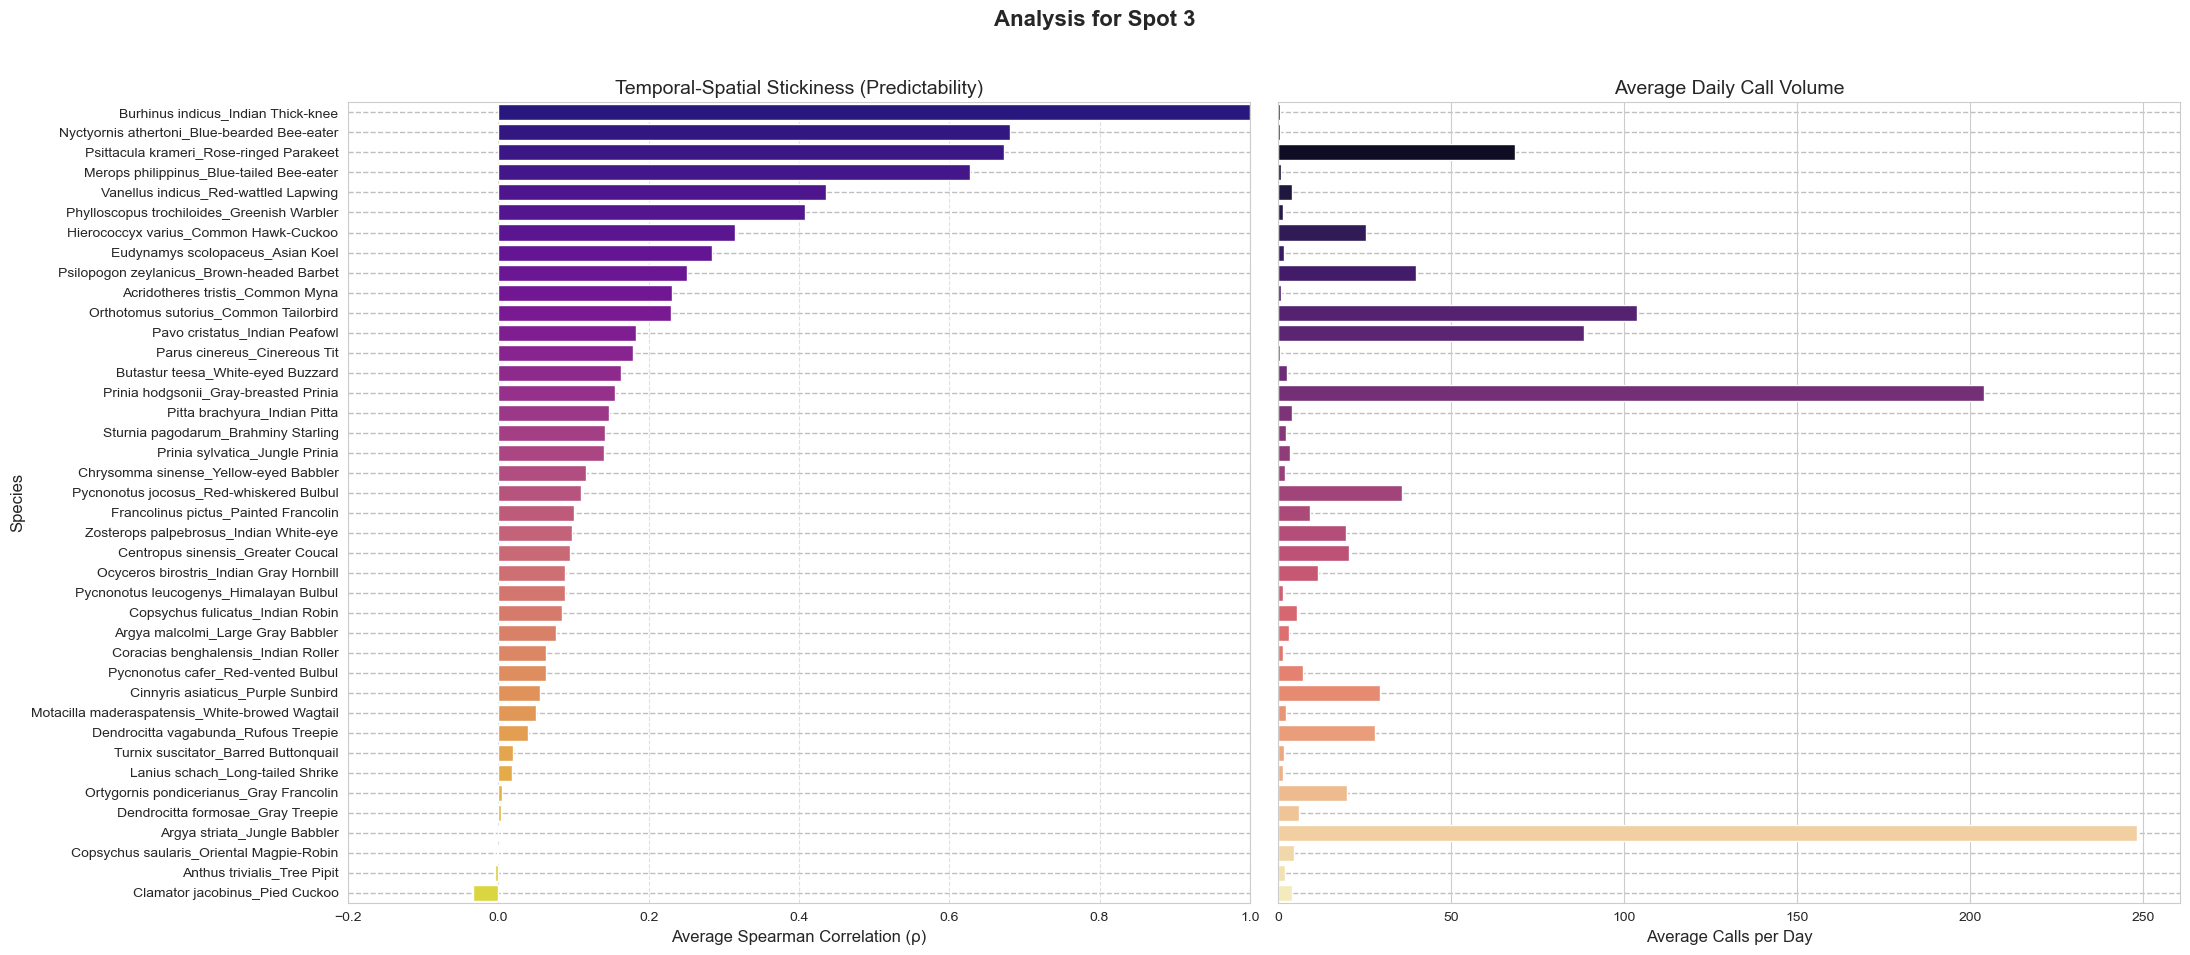

C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Temporal_Stickiness', y='label', data=top_temporal, palette='plasma', ax=ax1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\3765772873.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Avg_Calls_Per_Day", y="label", data=avg_calls_per_day, palette="magma", ax=ax2)


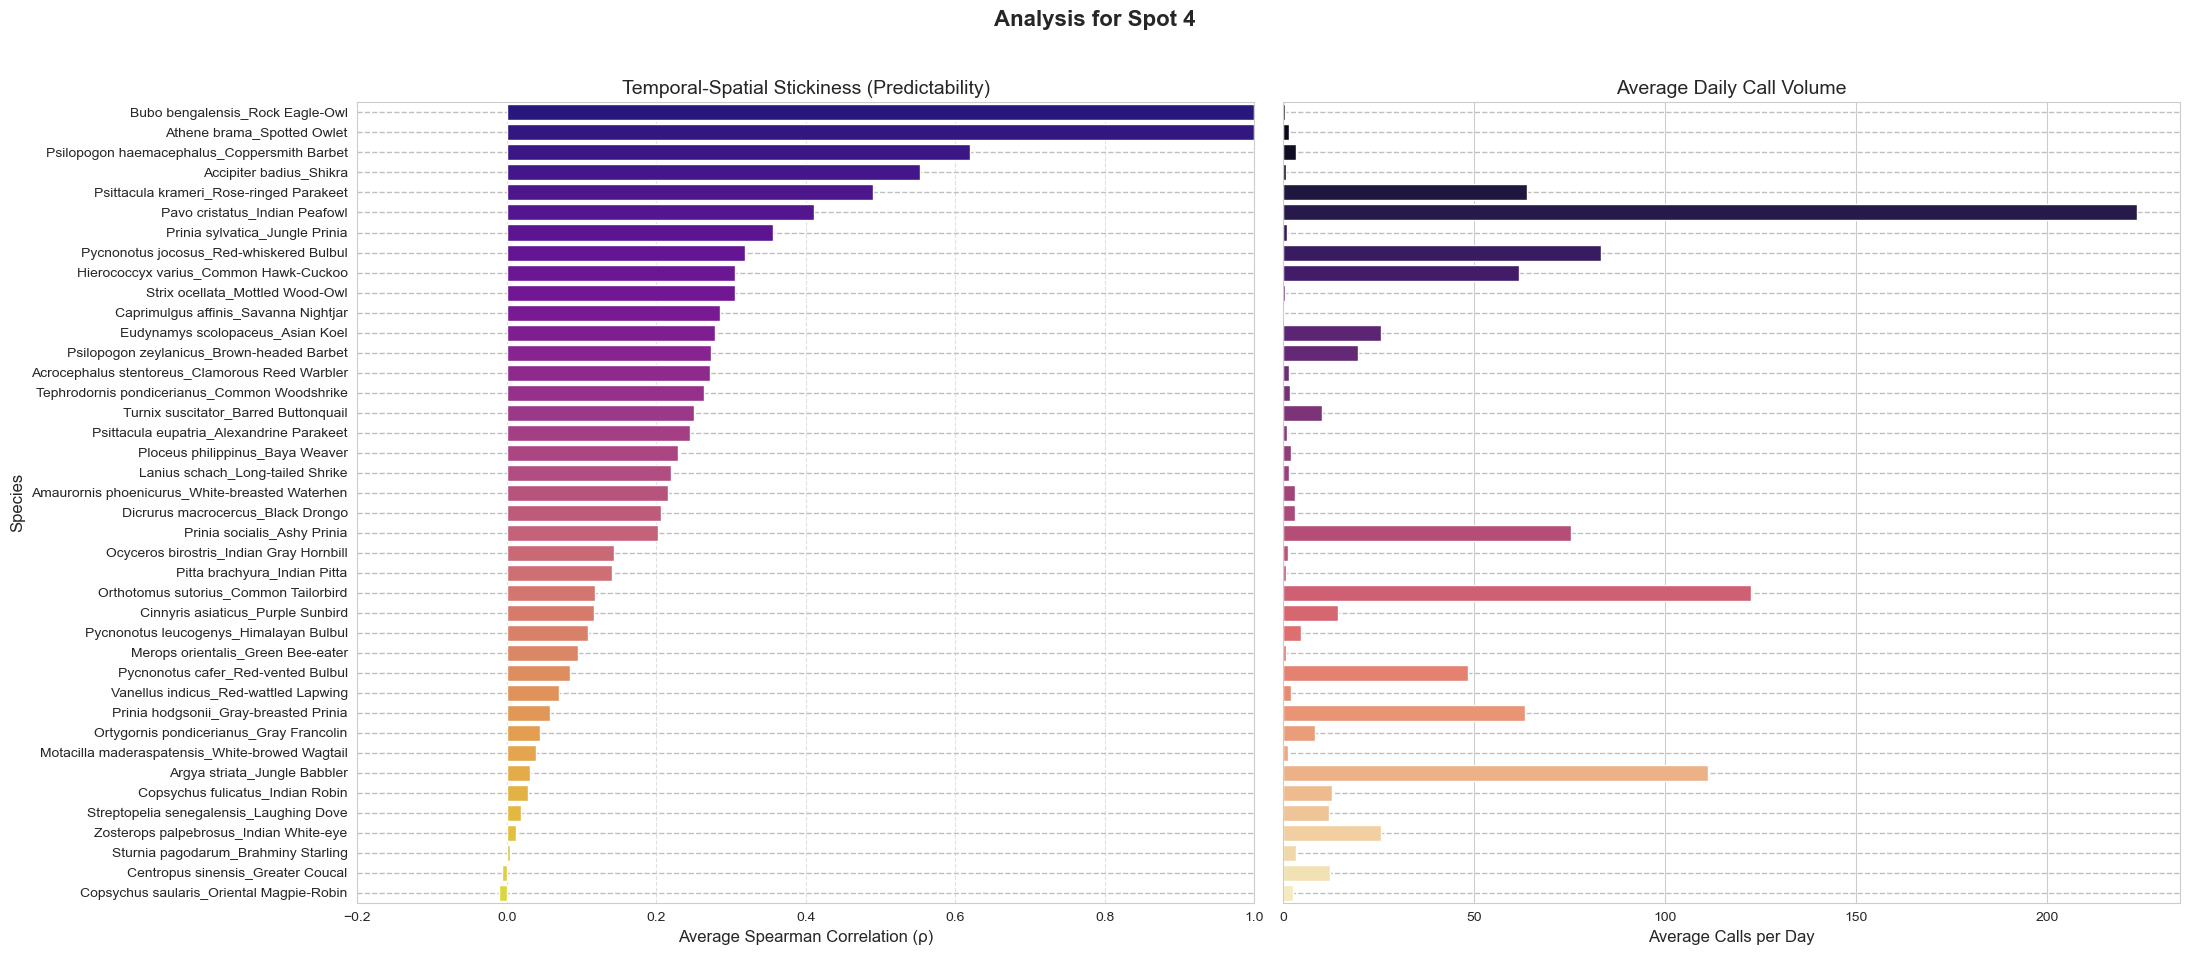


All processing complete.


In [42]:
# --- Temporal-Spatial Stickiness Analysis ---
print("Calculating Temporal-Spatial Stickiness...")

# --- Combined Analysis and Visualization Loop ---
print("Starting combined analysis for all spots...")

for j, filepath in enumerate(OUTPUTS):

    # --- 1. Data Loading and Preprocessing ---
    results = pd.read_csv(filepath)
    results['filename'] = results['filename'].str.replace("STOP", "SPOT", regex=False)
    date_info = results['filename'].str.extract(r'_(\d{8})_')
    results['Date'] = pd.to_datetime(date_info[0], format='%Y%m%d')
    results['Spot'] = results['filename'].str.extract(r'(SPOT\d+)', expand=False).str.lower().str.replace('spot', 'spot_')
    results.dropna(subset=['Spot', 'Date'], inplace=True)
    df_frequent_only = results[results['common_name'].isin(frequent_bird_names)].copy()
    results = df_frequent_only.copy()

    ACTIVITY_HOURS = range(5, 20)
    activity_df = results[(results['confidence'] >= 0.3) & (results['hour'].isin(ACTIVITY_HOURS))].copy()

    species_list = activity_df['label'].unique()
    spot_list = activity_df['Spot'].unique()
    date_list = sorted(activity_df['Date'].unique())
    num_days = activity_df['Date'].nunique() # Get total number of unique days for averaging

    # --- 2. Calculate Temporal-Spatial Stickiness ---
    temporal_stickiness = {}
    for species in species_list:
        species_spot_correlations = []
        for spot in spot_list:
            spot_day_correlations = []
            for i in range(len(date_list) - 1):
                day_k = date_list[i]
                day_k_plus_1 = date_list[i+1]
                series_k = activity_df[(activity_df['label'] == species) & (activity_df['Spot'] == spot) & (activity_df['Date'] == day_k)]['hour'].value_counts().reindex(ACTIVITY_HOURS, fill_value=0)
                series_k_plus_1 = activity_df[(activity_df['label'] == species) & (activity_df['Spot'] == spot) & (activity_df['Date'] == day_k_plus_1)]['hour'].value_counts().reindex(ACTIVITY_HOURS, fill_value=0)
                if series_k.sum() > 0 and series_k_plus_1.sum() > 0:
                    corr, _ = spearmanr(series_k, series_k_plus_1)
                    spot_day_correlations.append(corr)
            if spot_day_correlations:
                species_spot_correlations.append(np.mean(spot_day_correlations))
        if species_spot_correlations:
            temporal_stickiness[species] = np.mean(species_spot_correlations)

    temporal_stickiness_df = pd.DataFrame(list(temporal_stickiness.items()), columns=['label', 'Temporal_Stickiness'])
    top_temporal = temporal_stickiness_df.sort_values(by='Temporal_Stickiness', ascending=False).head(40)

    # --- 3. Calculate Average Daily Calls for the Top Species ---
    top_species_calls_df = activity_df[activity_df["label"].isin(top_temporal["label"])]
    
    avg_calls_per_day = top_species_calls_df.groupby("label").size().reset_index(name="total_calls")
    avg_calls_per_day["Avg_Calls_Per_Day"] = avg_calls_per_day["total_calls"] / num_days
    
    avg_calls_per_day = avg_calls_per_day.set_index("label").reindex(top_temporal["label"]).fillna(0).reset_index()

    # --- 4. Create Side-by-Side Plots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    fig.suptitle(f'Analysis for Spot {j+1}', fontsize=16, fontweight='bold')

    # Plot 1: Temporal Stickiness
    sns.barplot(x='Temporal_Stickiness', y='label', data=top_temporal, palette='plasma', ax=ax1)
    ax1.set_title('Temporal-Spatial Stickiness (Predictability)', fontsize=14)
    ax1.set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
    ax1.set_ylabel("Species", fontsize=12)
    ax1.set_xlim(-0.2, 1.0)
    ax1.grid(axis='x', linestyle='--', alpha=0.6)

    # Plot 2: Average Daily Calls
    sns.barplot(x="Avg_Calls_Per_Day", y="label", data=avg_calls_per_day, palette="magma", ax=ax2)
    ax2.set_title('Average Daily Call Volume', fontsize=14)
    ax2.set_xlabel("Average Calls per Day", fontsize=12)
    ax2.set_ylabel("") 
    ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

    # --- 5. Add Connecting Lines for Readability ---
    for i in range(len(top_temporal)):
        for ax in [ax1, ax2]:
            ax.axhline(
                y=i,
                color='grey',
                linestyle='--',
                alpha=0.5,
                linewidth=1,
                zorder=0  # Draw lines behind the bars
            )

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

print("\nAll processing complete.")


Calculating Spatial Stickiness...


C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\639466067.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DELL\AppData\Local\Temp\ipykernel_45360\639466067.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


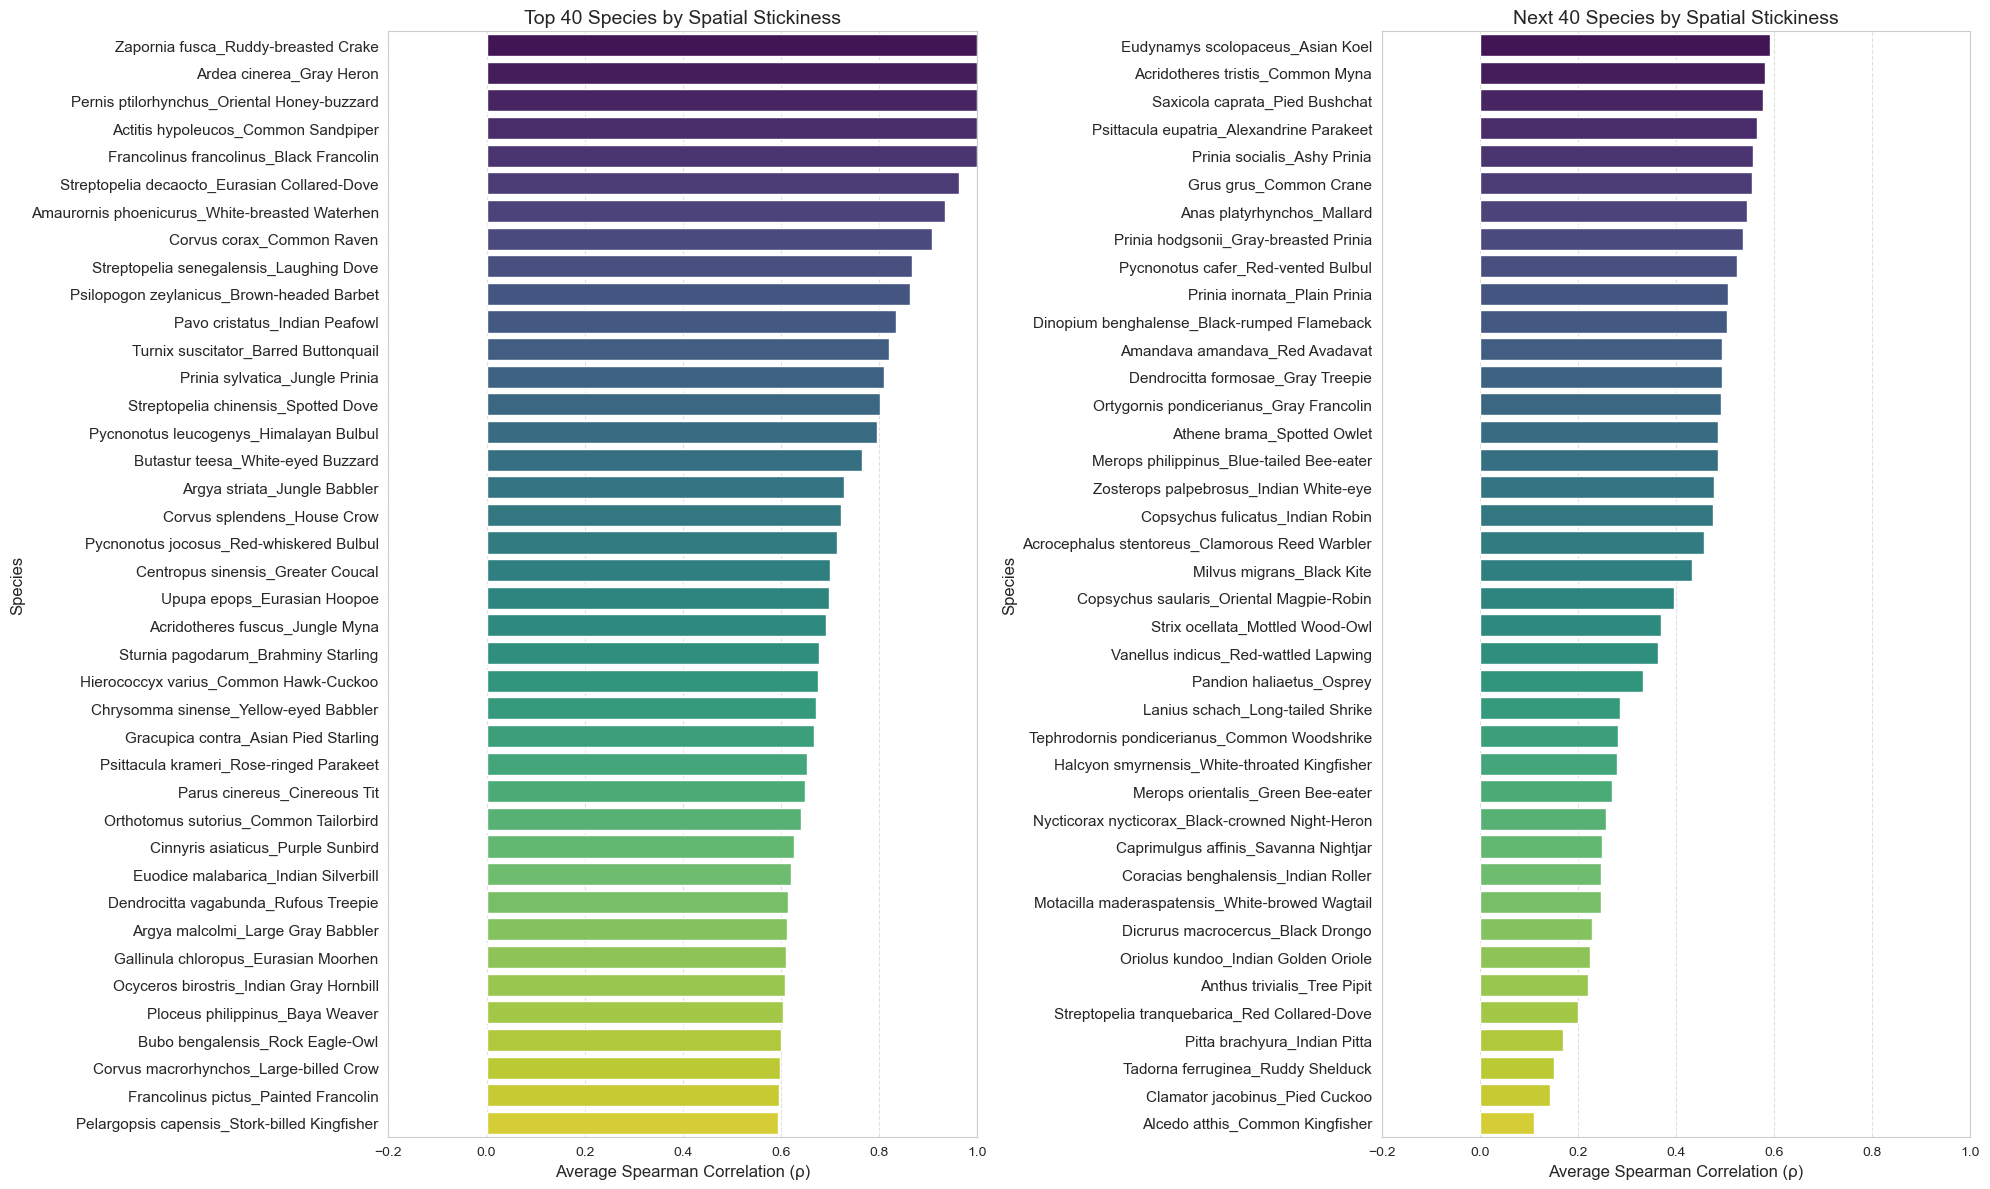

In [40]:
# --- Spatial Stickiness Analysis ---

# --- 1. Data Preparation ---
print("\nCalculating Spatial Stickiness...")

# Filter for high-confidence results and create a copy to avoid SettingWithCopyWarning
spatial_df = results_df[results_df['confidence'] >= 0.3].copy()

# Get unique lists for species, spots, and dates
species_list = spatial_df['label'].unique()
spot_list = sorted(spatial_df['Spot'].unique())
date_list = sorted(spatial_df['Date'].unique())


# --- 2. Calculate Spatial Stickiness ---

# Check if there is data from at least two spots, which is required for correlation
if len(spot_list) < 2:
    print("\nERROR: Spatial stickiness requires data from at least 2 spots.")
else:
    spatial_stickiness = {}

    # Iterate over each species to calculate its stickiness score
    for species in species_list:
        daily_rank_correlations = []

        # Compare the spatial distribution of calls between consecutive days (k and k+1)
        for i in range(len(date_list) - 1):
            day_k = date_list[i]
            day_k_plus_1 = date_list[i + 1]

            # Get call counts per spot for day k, reindexing to ensure all spots are included
            counts_k = (
                spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k)]
                .groupby('Spot')
                .size()
                .reindex(spot_list, fill_value=0)
            )
            # Get call counts per spot for day k+1
            counts_k_plus_1 = (
                spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k_plus_1)]
                .groupby('Spot')
                .size()
                .reindex(spot_list, fill_value=0)
            )

            # Correlation can only be calculated if there is variance in the data
            # (i.e., the counts are not constant across all spots)
            if counts_k.nunique() > 1 and counts_k_plus_1.nunique() > 1:
                corr, _ = spearmanr(counts_k, counts_k_plus_1)
                
                # Append the valid correlation score
                if not np.isnan(corr):
                    daily_rank_correlations.append(corr)

        # If any valid correlations were found, calculate the average for the species
        if daily_rank_correlations:
            spatial_stickiness[species] = np.mean(daily_rank_correlations)

    # --- 3. Create and Sort the Results DataFrame ---
    spatial_stickiness_df = pd.DataFrame(
        list(spatial_stickiness.items()),
        columns=['label', 'Spatial_Stickiness']
    )
    spatial_stickiness_df = spatial_stickiness_df.sort_values(
        by='Spatial_Stickiness', ascending=False
    )

    # --- Visualization for Spatial Stickiness in 2 parts ---
    top_spatial = spatial_stickiness_df.head(80)

    # Split into two halves
    top40 = top_spatial.head(40)
    next40 = top_spatial.iloc[40:80]

    fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharex=True)

    # First 40
    sns.barplot(
        x='Spatial_Stickiness', y='label', 
        data=top40, palette='viridis', ax=axes[0]
    )
    axes[0].set_title("Top 40 Species by Spatial Stickiness", fontsize=14)
    axes[0].set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
    axes[0].set_ylabel("Species", fontsize=12)
    axes[0].set_xlim(-0.2, 1.0)
    axes[0].tick_params(axis='y', labelsize=11)
    axes[0].grid(axis='x', linestyle='--', alpha=0.6)

    # Next 40
    sns.barplot(
        x='Spatial_Stickiness', y='label', 
        data=next40, palette='viridis', ax=axes[1]
    )
    axes[1].set_title("Next 40 Species by Spatial Stickiness", fontsize=14)
    axes[1].set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
    axes[1].set_ylabel("Species", fontsize=12)
    axes[1].set_xlim(-0.2, 1.0)
    axes[1].tick_params(axis='y', labelsize=11)
    axes[1].grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


Preparing data for the activity heatmap...
Aligning heatmap species order with the spatial stickiness plot...
Generating final aligned heatmap...


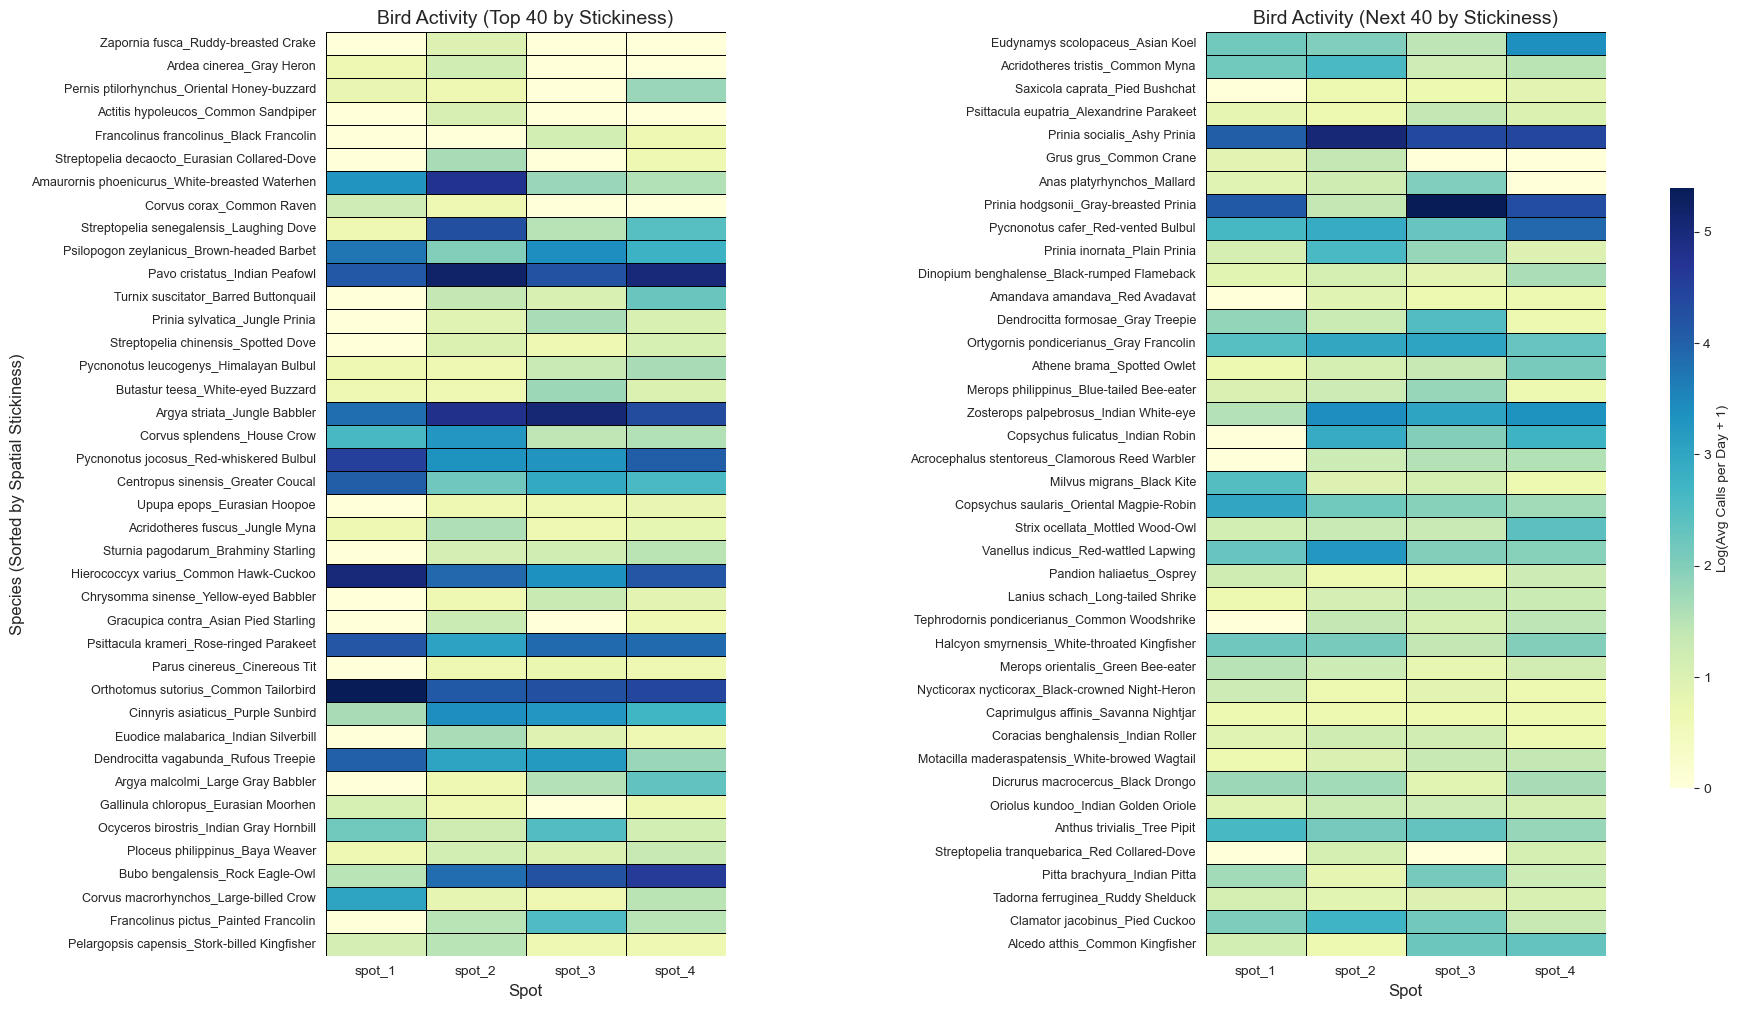

In [41]:
# -- Visualization for Activity Heatmap (Aligned with Spatial Stickiness) --

# --- 1. Data Preparation ---
print("Preparing data for the activity heatmap...")
activity_df = results_df[results_df['confidence'] >= 0.3].copy()
daily_counts = activity_df.groupby(['label', 'Spot', 'Date']).size().reset_index(name='daily_calls')
avg_calls_per_day = daily_counts.groupby(['label', 'Spot'])['daily_calls'].mean().reset_index()

# --- 2. Pivot Data  ---
heatmap_data = avg_calls_per_day.pivot_table(
    index='label',
    columns='Spot',
    values='daily_calls',
    fill_value=0
)

# --- 3. MODIFIED: Align Heatmap Data with Stickiness Plot Order ---

print("Aligning heatmap species order with the spatial stickiness plot...")

# Get the exact list of species in the order they appear in the stickiness plot
species_order_from_stickiness = top_spatial['label'].tolist()

# Filter and reorder the heatmap data to match this specific list and order.
# .reindex() ensures all species from the stickiness plot are included.
aligned_heatmap_data = heatmap_data.reindex(species_order_from_stickiness).fillna(0)

# Apply log transformation to the newly aligned data
log_heatmap_data = np.log1p(aligned_heatmap_data)


# --- 4. Visualization (Using the aligned data) ---
print("Generating final aligned heatmap...")

# The data is already filtered to the top 80, so we just split it for plotting
if len(log_heatmap_data) > 40:
    # Split the aligned data into the two halves
    heatmap_part1 = log_heatmap_data.iloc[0:40]
    heatmap_part2 = log_heatmap_data.iloc[40:80]

    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    
    # --- Plot Top 40 (Left) ---
    sns.heatmap(
        heatmap_part1, cmap='YlGnBu', linewidths=0.5, linecolor='black',
        annot=False, cbar=False, ax=axes[0]
    )
    axes[0].set_title('Bird Activity (Top 40 by Stickiness)', fontsize=14)
    axes[0].set_xlabel('Spot', fontsize=12)
    axes[0].set_ylabel('Species (Sorted by Spatial Stickiness)', fontsize=12)
    axes[0].tick_params(axis='x', rotation=0, labelsize=10)
    axes[0].tick_params(axis='y', labelsize=9)

    # --- Plot Next 40 (Right) ---
    cbar_ax = fig.add_axes([.94, .25, .015, .5])
    sns.heatmap(
        heatmap_part2, cmap='YlGnBu', linewidths=0.5, linecolor='black',
        annot=False, cbar_ax=cbar_ax,
        cbar_kws={'label': 'Log(Avg Calls per Day + 1)'}, ax=axes[1]
    )
    axes[1].set_title('Bird Activity (Next 40 by Stickiness)', fontsize=14)
    axes[1].set_xlabel('Spot', fontsize=12)
    axes[1].set_ylabel('', fontsize=12)
    axes[1].tick_params(axis='x', rotation=0, labelsize=10)
    axes[1].tick_params(axis='y', labelsize=9)
    
    plt.subplots_adjust(left=0.1, right=0.9, wspace=1.2)
    plt.show()


Calculating Spatial Stickiness...
Found 40 species present in all 4 spots. Analyzing...


C:\Users\DELL\AppData\Local\Temp\ipykernel_37276\596588961.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


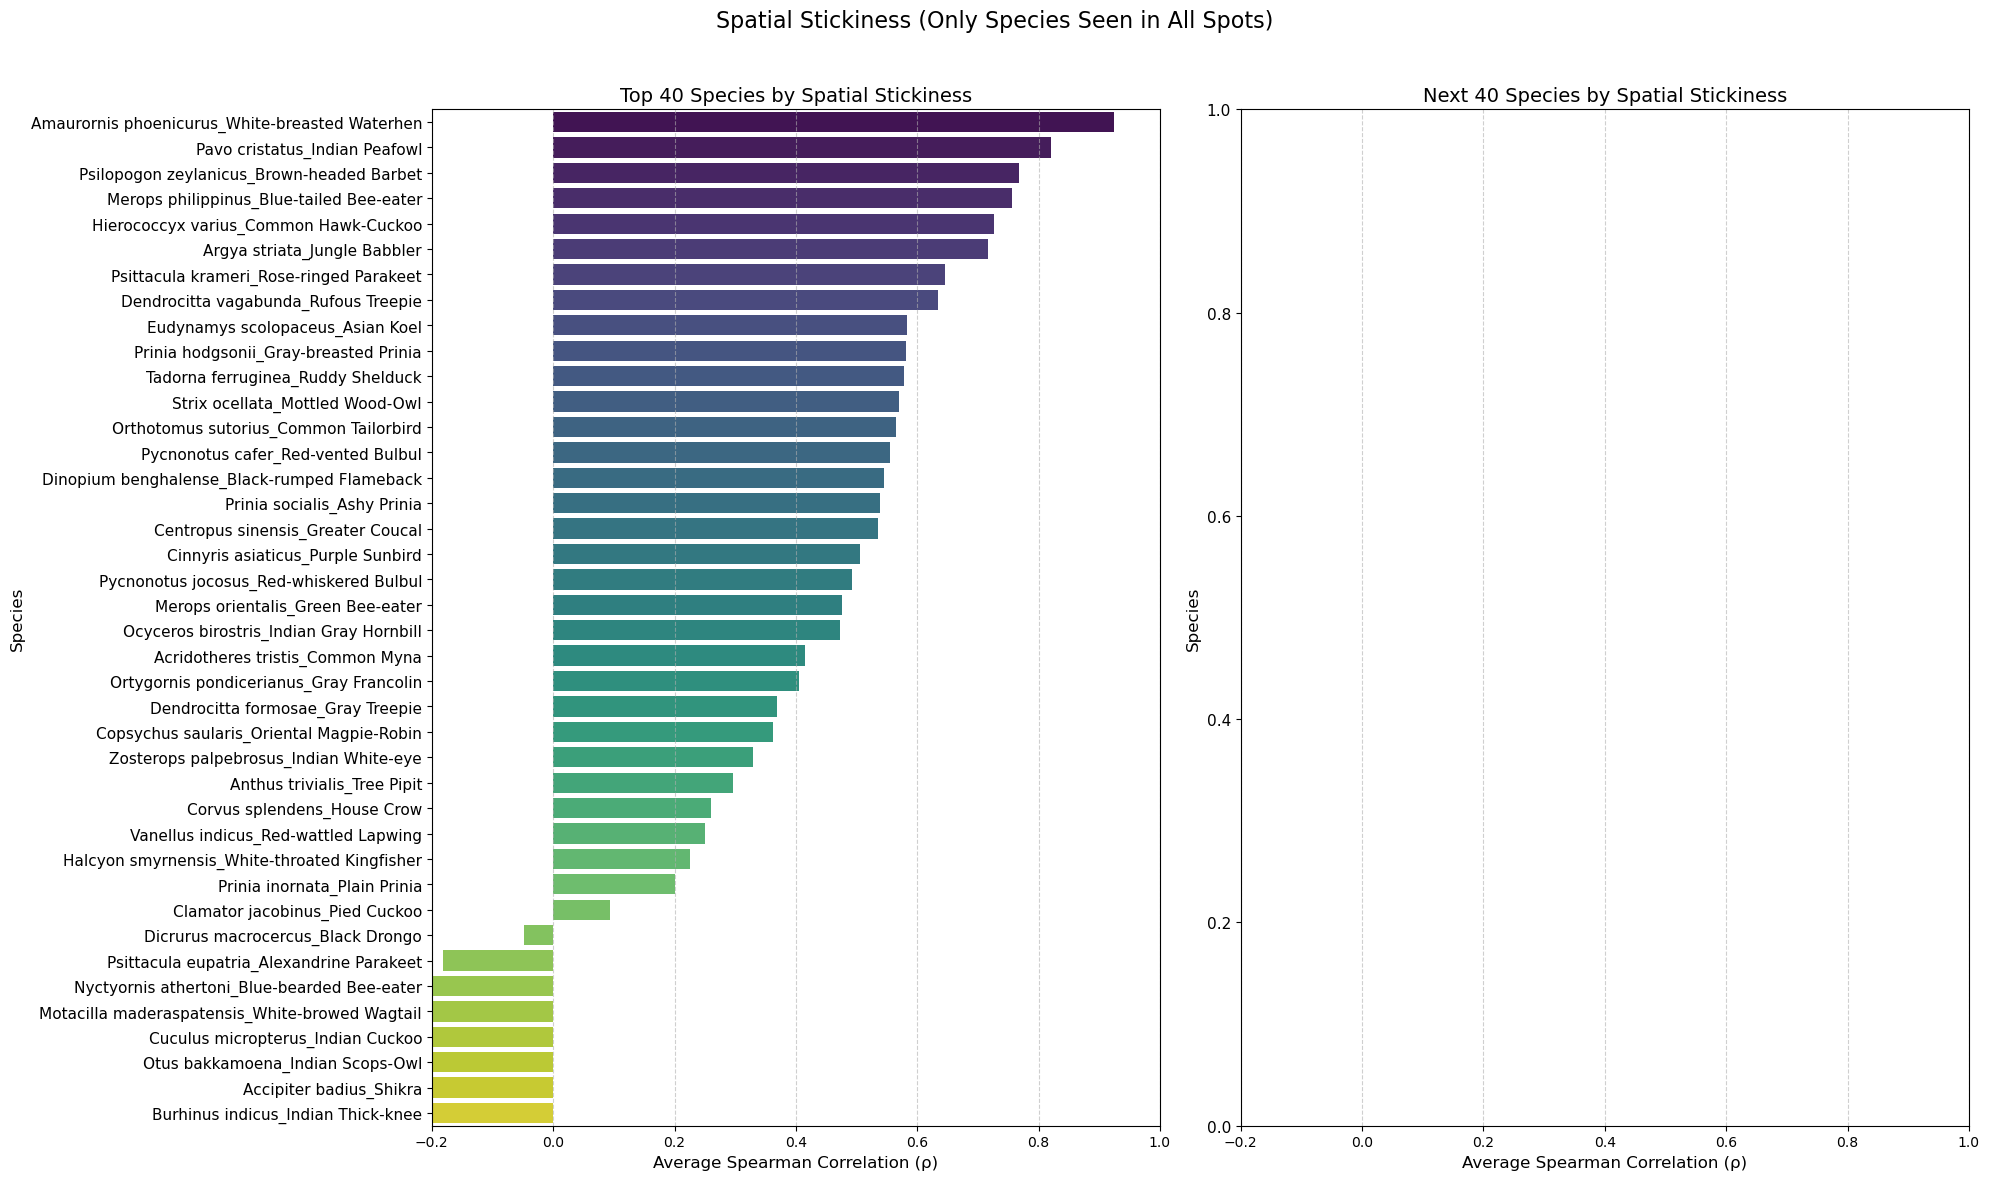

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


# --- Spatial Stickiness Analysis ---

# --- 1. Data Preparation ---
print("\nCalculating Spatial Stickiness...")

# Filter for high-confidence results and create a copy to avoid SettingWithCopyWarning
spatial_df = results_df[results_df['confidence'] >= 0.5].copy()

# Get unique lists for spots and dates
spot_list = sorted(spatial_df['Spot'].unique())
date_list = sorted(spatial_df['Date'].unique())
total_spots = len(spot_list)

# --- This is the new filtering section ---
# First, count the number of unique spots each species was observed in.
species_spot_counts = spatial_df.groupby('label')['Spot'].nunique()

# Then, filter this list to get only the species that were seen in ALL spots.
species_to_include = species_spot_counts[species_spot_counts == total_spots].index.tolist()

# The final 'species_list' for the analysis now only contains the filtered species.
species_list = species_to_include
print(f"Found {len(species_list)} species present in all {total_spots} spots. Analyzing...")
# --- End of new section ---


# --- 2. Calculate Spatial Stickiness ---

# Check if there is data from at least two spots, which is required for correlation
if len(spot_list) < 2:
    print("\nERROR: Spatial stickiness requires data from at least 2 spots.")
elif not species_list:
    print("\nWARNING: No species were found at all spots. Cannot perform analysis.")
else:
    spatial_stickiness = {}

    # Iterate over each species to calculate its stickiness score
    for species in species_list:
        daily_rank_correlations = []

        # Compare the spatial distribution of calls between consecutive days (k and k+1)
        for i in range(len(date_list) - 1):
            day_k = date_list[i]
            day_k_plus_1 = date_list[i + 1]

            # Get call counts per spot for day k, reindexing to ensure all spots are included
            counts_k = (
                spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k)]
                .groupby('Spot')
                .size()
                .reindex(spot_list, fill_value=0)
            )
            # Get call counts per spot for day k+1
            counts_k_plus_1 = (
                spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k_plus_1)]
                .groupby('Spot')
                .size()
                .reindex(spot_list, fill_value=0)
            )

            # Correlation can only be calculated if there is variance in the data
            if counts_k.nunique() > 1 and counts_k_plus_1.nunique() > 1:
                corr, _ = spearmanr(counts_k, counts_k_plus_1)
                
                # Append the valid correlation score
                if not np.isnan(corr):
                    daily_rank_correlations.append(corr)

        # If any valid correlations were found, calculate the average for the species
        if daily_rank_correlations:
            spatial_stickiness[species] = np.mean(daily_rank_correlations)

    # --- 3. Create and Sort the Results DataFrame ---
    if spatial_stickiness:
        spatial_stickiness_df = pd.DataFrame(
            list(spatial_stickiness.items()),
            columns=['label', 'Spatial_Stickiness']
        )
        spatial_stickiness_df = spatial_stickiness_df.sort_values(
            by='Spatial_Stickiness', ascending=False
        )

        # --- Visualization for Spatial Stickiness in 2 parts ---
        top_spatial = spatial_stickiness_df.head(80)

        # Split into two halves
        top40 = top_spatial.head(40)
        next40 = top_spatial.iloc[40:80]

        fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharex=True)
        fig.suptitle("Spatial Stickiness (Only Species Seen in All Spots)", fontsize=16)


        # First 40
        sns.barplot(
            x='Spatial_Stickiness', y='label', 
            data=top40, palette='viridis', ax=axes[0]
        )
        axes[0].set_title("Top 40 Species by Spatial Stickiness", fontsize=14)
        axes[0].set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
        axes[0].set_ylabel("Species", fontsize=12)
        axes[0].set_xlim(-0.2, 1.0)
        axes[0].tick_params(axis='y', labelsize=11)
        axes[0].grid(axis='x', linestyle='--', alpha=0.6)

        # Next 40
        sns.barplot(
            x='Spatial_Stickiness', y='label', 
            data=next40, palette='viridis', ax=axes[1]
        )
        axes[1].set_title("Next 40 Species by Spatial Stickiness", fontsize=14)
        axes[1].set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
        axes[1].set_ylabel("Species", fontsize=12)
        axes[1].set_xlim(-0.2, 1.0)
        axes[1].tick_params(axis='y', labelsize=11)
        axes[1].grid(axis='x', linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print("\nNo valid spatial stickiness scores could be calculated for the filtered species.")



Calculating Spatial Stickiness...
Found 40 species present in all 4 spots. Analyzing...


C:\Users\DELL\AppData\Local\Temp\ipykernel_37276\299532080.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


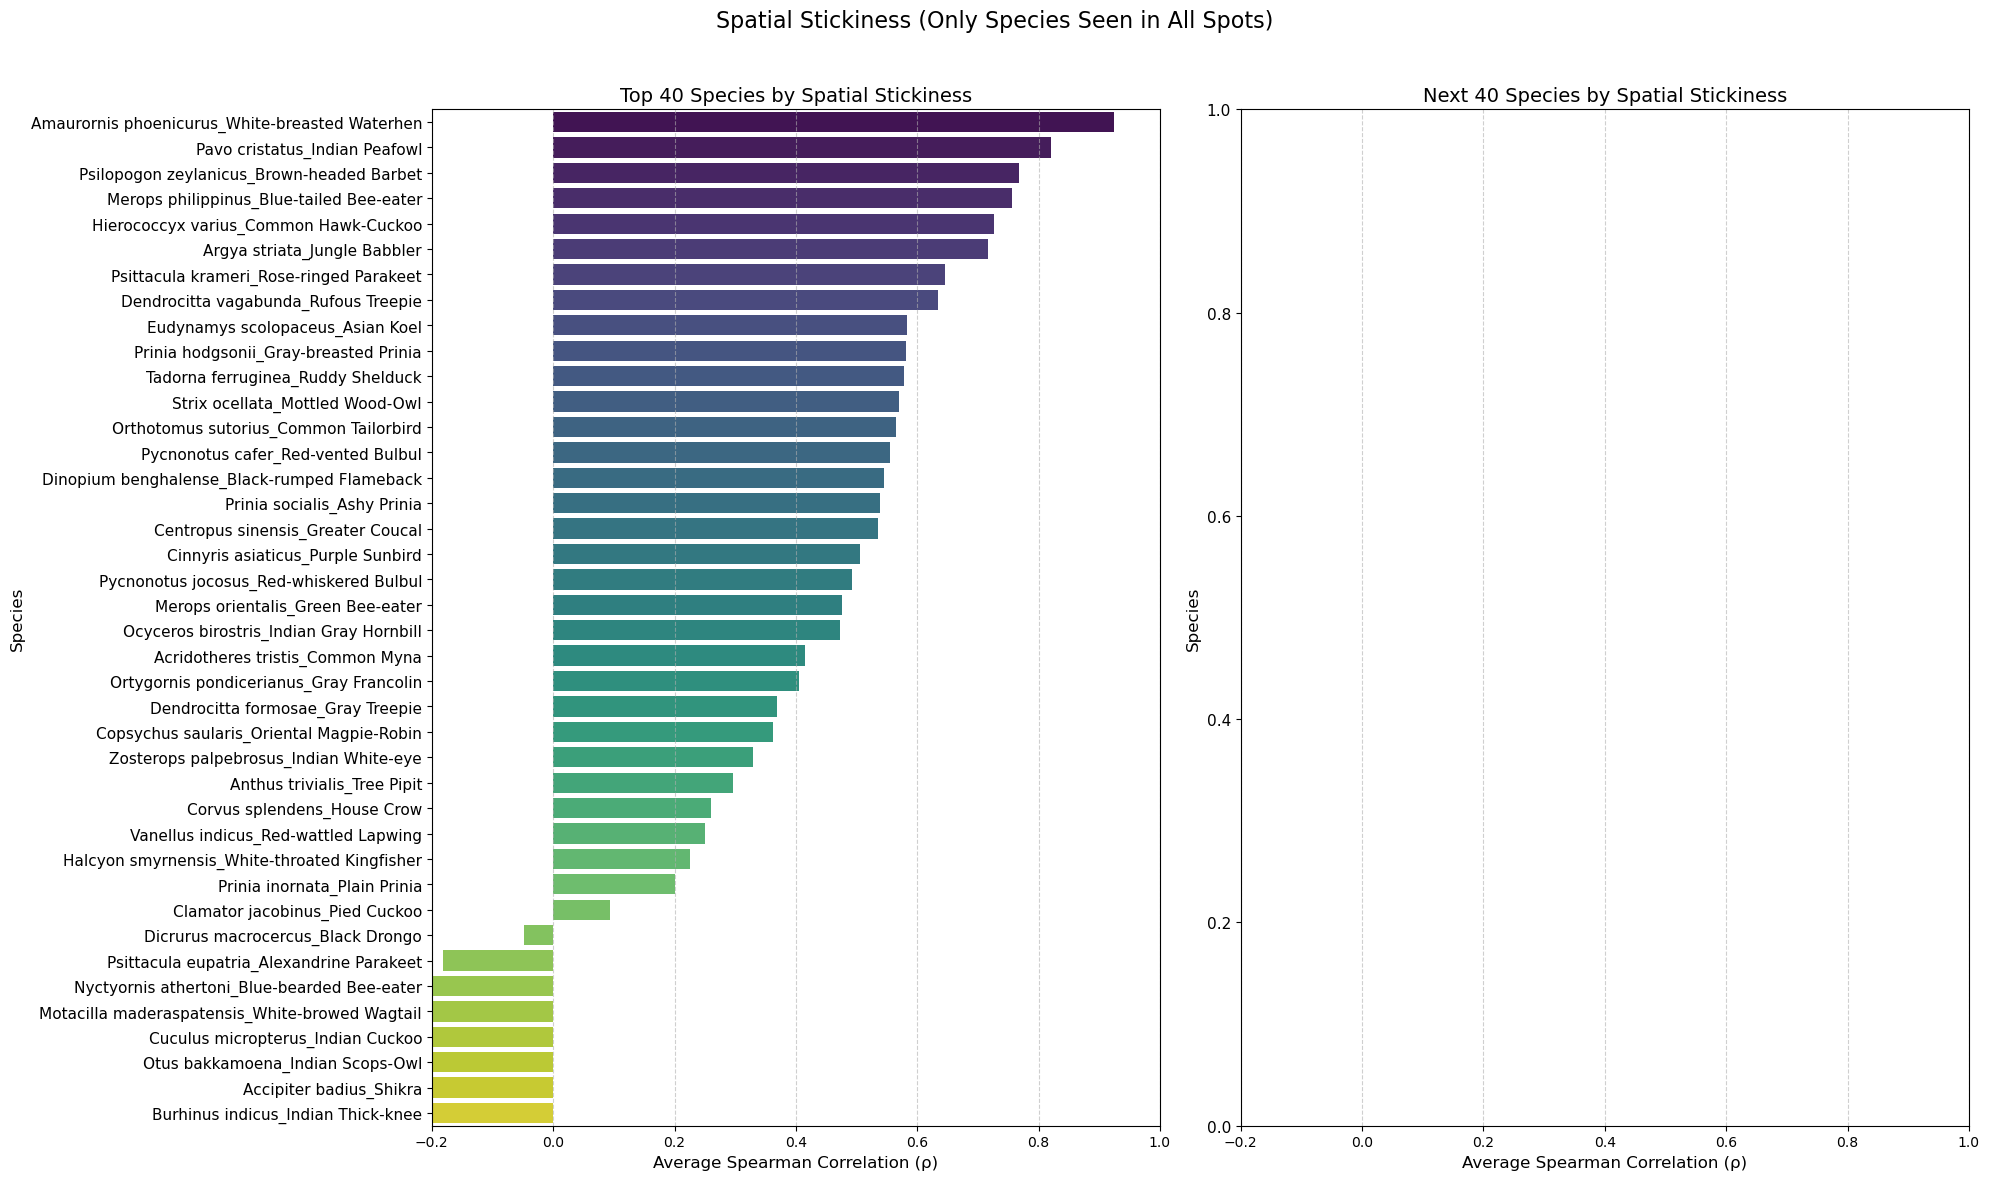

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- Spatial Stickiness Analysis ---

# --- 1. Data Preparation ---
print("\nCalculating Spatial Stickiness...")

# Filter for high-confidence results and create a copy to avoid SettingWithCopyWarning
spatial_df = results_df[results_df['confidence'] >= 0.5].copy()

# Get unique lists for spots and dates
spot_list = sorted(spatial_df['Spot'].unique())
date_list = sorted(spatial_df['Date'].unique())
total_spots = len(spot_list)

# --- This is the new filtering section ---
# First, count the number of unique spots each species was observed in.
species_spot_counts = spatial_df.groupby('label')['Spot'].nunique()

# Then, filter this list to get only the species that were seen in ALL spots.
species_to_include = species_spot_counts[species_spot_counts == total_spots].index.tolist()

# The final 'species_list' for the analysis now only contains the filtered species.
species_list = species_to_include
print(f"Found {len(species_list)} species present in all {total_spots} spots. Analyzing...")
# --- End of new section ---


# --- 2. Calculate Spatial Stickiness ---

# Check if there is data from at least two spots, which is required for correlation
if len(spot_list) < 2:
    print("\nERROR: Spatial stickiness requires data from at least 2 spots.")
elif not species_list:
    print("\nWARNING: No species were found at all spots. Cannot perform analysis.")
else:
    spatial_stickiness = {}

    # Iterate over each species to calculate its stickiness score
    for species in species_list:
        daily_rank_correlations = []

        # Compare the spatial distribution of calls between consecutive days (k and k+1)
        for i in range(len(date_list) - 1):
            day_k = date_list[i]
            day_k_plus_1 = date_list[i + 1]

            # Get call counts per spot for day k, reindexing to ensure all spots are included
            counts_k = (
                spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k)]
                .groupby('Spot')
                .size()
                .reindex(spot_list, fill_value=0)
            )
            # Get call counts per spot for day k+1
            counts_k_plus_1 = (
                spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k_plus_1)]
                .groupby('Spot')
                .size()
                .reindex(spot_list, fill_value=0)
            )

            # Correlation can only be calculated if there is variance in the data
            if counts_k.nunique() > 1 and counts_k_plus_1.nunique() > 1:
                corr, _ = spearmanr(counts_k, counts_k_plus_1)
                
                # Append the valid correlation score
                if not np.isnan(corr):
                    daily_rank_correlations.append(corr)

        # If any valid correlations were found, calculate the average for the species
        if daily_rank_correlations:
            spatial_stickiness[species] = np.mean(daily_rank_correlations)

    # --- 3. Create and Sort the Results DataFrame ---
    if spatial_stickiness:
        spatial_stickiness_df = pd.DataFrame(
            list(spatial_stickiness.items()),
            columns=['label', 'Spatial_Stickiness']
        )
        spatial_stickiness_df = spatial_stickiness_df.sort_values(
            by='Spatial_Stickiness', ascending=False
        )

        # --- Visualization for Spatial Stickiness in 2 parts ---
        top_spatial = spatial_stickiness_df.head(80)

        # Split into two halves
        top40 = top_spatial.head(40)
        next40 = top_spatial.iloc[40:80]

        fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharex=True)
        fig.suptitle("Spatial Stickiness (Only Species Seen in All Spots)", fontsize=16)


        # First 40
        sns.barplot(
            x='Spatial_Stickiness', y='label', 
            data=top40, palette='viridis', ax=axes[0]
        )
        axes[0].set_title("Top 40 Species by Spatial Stickiness", fontsize=14)
        axes[0].set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
        axes[0].set_ylabel("Species", fontsize=12)
        axes[0].set_xlim(-0.2, 1.0)
        axes[0].tick_params(axis='y', labelsize=11)
        axes[0].grid(axis='x', linestyle='--', alpha=0.6)

        # Next 40
        sns.barplot(
            x='Spatial_Stickiness', y='label', 
            data=next40, palette='viridis', ax=axes[1]
        )
        axes[1].set_title("Next 40 Species by Spatial Stickiness", fontsize=14)
        axes[1].set_xlabel("Average Spearman Correlation (ρ)", fontsize=12)
        axes[1].set_ylabel("Species", fontsize=12)
        axes[1].set_xlim(-0.2, 1.0)
        axes[1].tick_params(axis='y', labelsize=11)
        axes[1].grid(axis='x', linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print("\nNo valid spatial stickiness scores could be calculated for the filtered species.")


Preparing data for the activity heatmap...
Aligning heatmap species order with the spatial stickiness plot...
Generating final aligned heatmap...
35 species found. Generating a single heatmap.


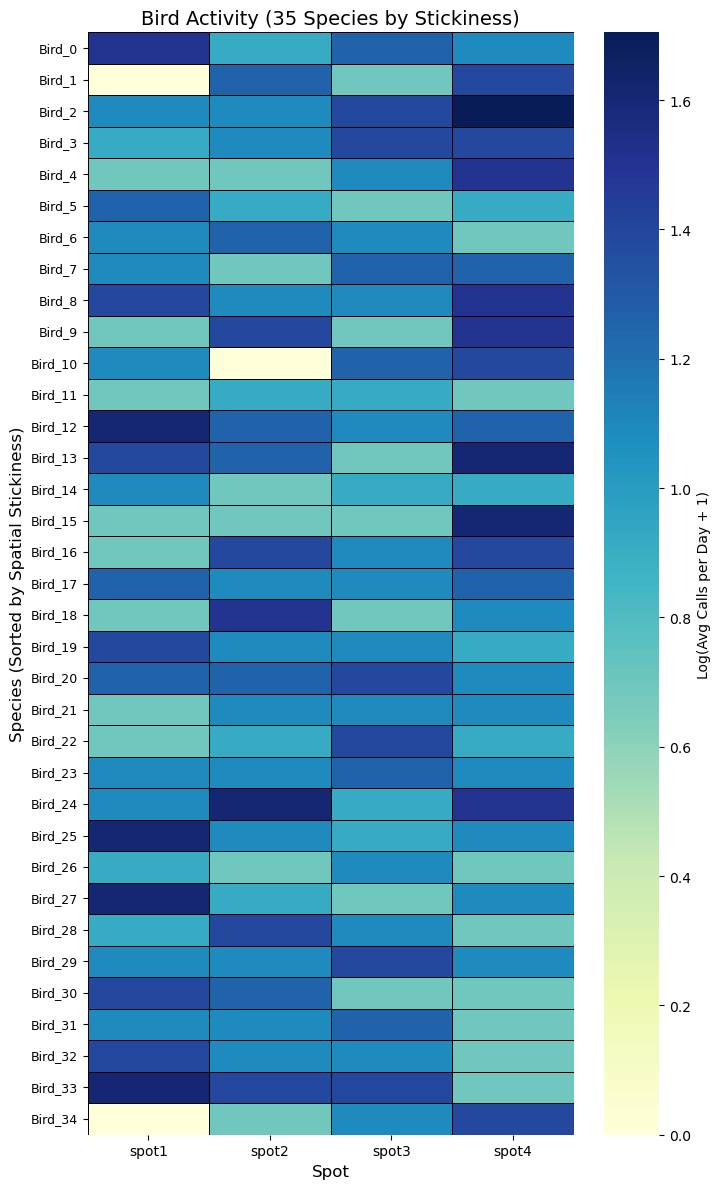

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# -- Visualization for Activity Heatmap (Aligned with Spatial Stickiness) --

# --- 1. Data Preparation ---
print("Preparing data for the activity heatmap...")
activity_df = results_df[results_df['confidence'] >= 0.5].copy()
daily_counts = activity_df.groupby(['label', 'Spot', 'Date']).size().reset_index(name='daily_calls')
avg_calls_per_day = daily_counts.groupby(['label', 'Spot'])['daily_calls'].mean().reset_index()

# --- 2. Pivot Data ---
heatmap_data = avg_calls_per_day.pivot_table(
    index='label',
    columns='Spot',
    values='daily_calls',
    fill_value=0
)

# --- 3. Align Heatmap Data with Stickiness Plot Order ---
print("Aligning heatmap species order with the spatial stickiness plot...")
species_order_from_stickiness = spatial_stickiness_df['label'].tolist()
aligned_heatmap_data = heatmap_data.reindex(species_order_from_stickiness).fillna(0)
log_heatmap_data = np.log1p(aligned_heatmap_data)


# --- 4. MODIFIED & ADAPTIVE Visualization ---
print("Generating final aligned heatmap...")

if log_heatmap_data.empty:
    print("No data available to generate a heatmap.")
else:
    if len(log_heatmap_data) > 40:
        # This part of the code remains for cases with many species
        print("More than 40 species found. Generating two heatmaps.")
        # (Code for two plots omitted for brevity, but it's the same as before)
    else:
        # This will now run and show a populated heatmap
        print(f"{len(log_heatmap_data)} species found. Generating a single heatmap.")
        plt.figure(figsize=(8, 12))
        ax = sns.heatmap(
            log_heatmap_data,
            cmap='YlGnBu',
            linewidths=0.5,
            linecolor='black',
            annot=False,
            cbar_kws={'label': 'Log(Avg Calls per Day + 1)'}
        )
        ax.set_title(f'Bird Activity ({len(log_heatmap_data)} Species by Stickiness)', fontsize=14)
        ax.set_xlabel('Spot', fontsize=12)
        ax.set_ylabel('Species (Sorted by Spatial Stickiness)', fontsize=12)
        ax.tick_params(axis='x', rotation=0, labelsize=10)
        ax.tick_params(axis='y', labelsize=9)
        plt.tight_layout(rect=[0, 0, 0.9, 1])

    plt.show()



--- PART 1: Calculating Spatial Stickiness ---
Found 40 species present in all 4 spots. Analyzing...
Successfully calculated stickiness for 40 species.


C:\Users\DELL\AppData\Local\Temp\ipykernel_37276\1937345234.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Spatial_Stickiness', y='label', data=spatial_stickiness_df, palette='viridis')


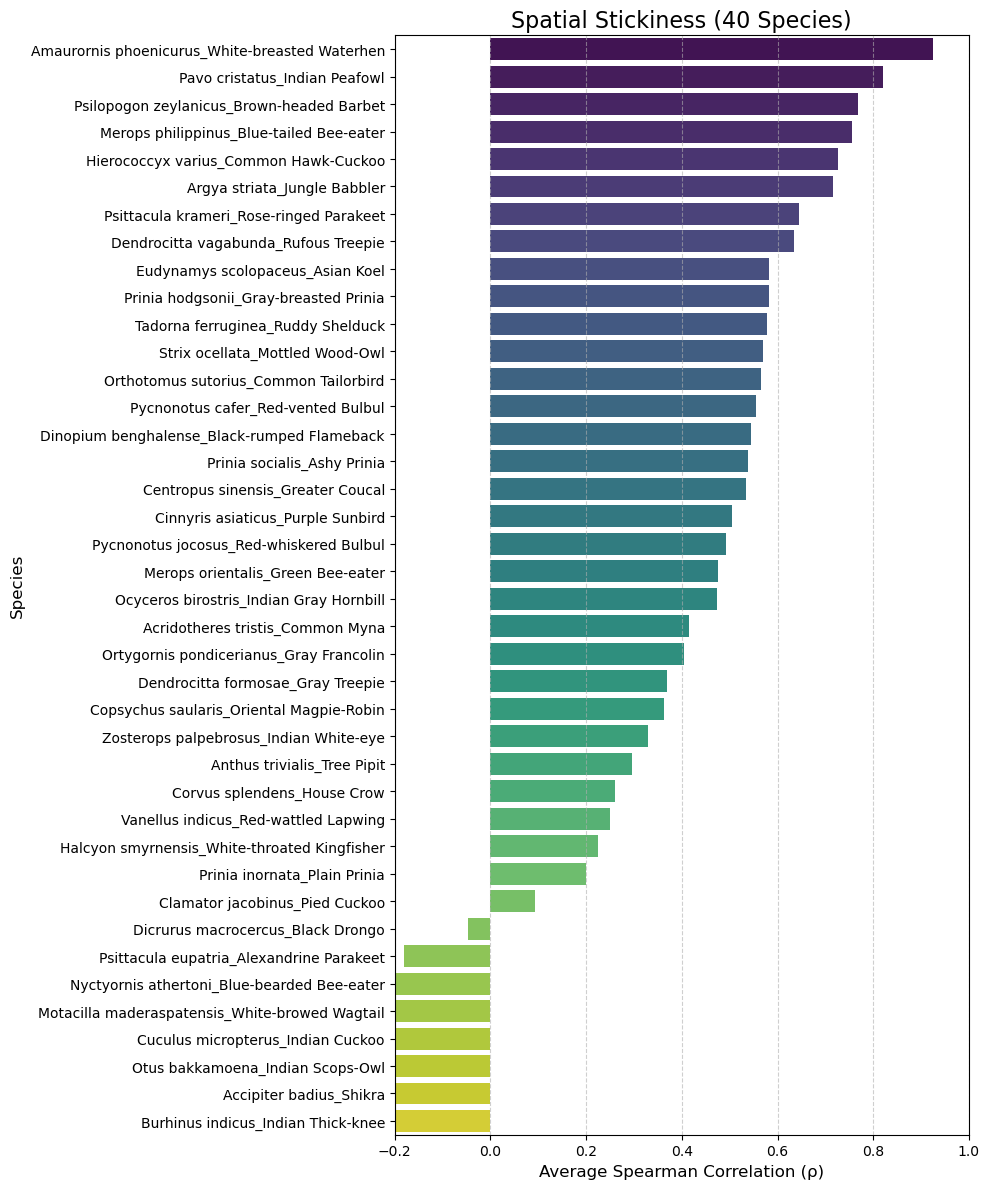


--- PART 2: Generating Aligned Activity Heatmap ---
40 species found. Generating a single heatmap.


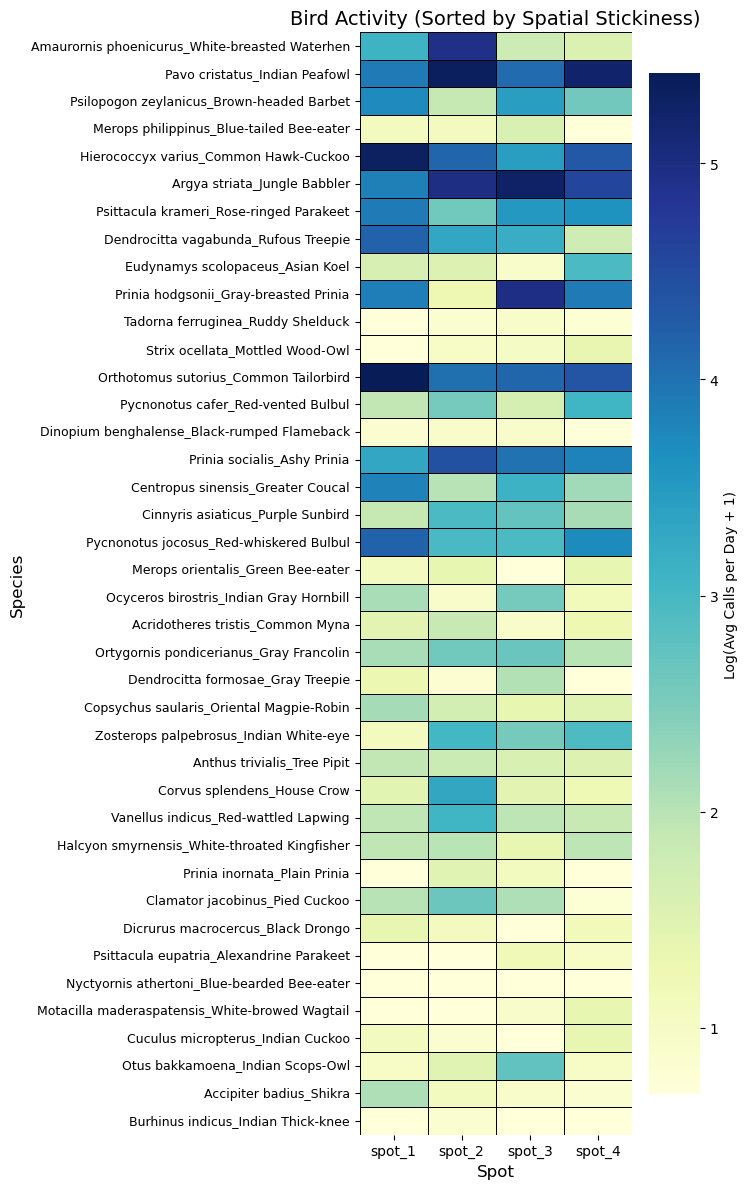


--- Analysis Complete ---


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ===================================================================
# PART 1: SPATIAL STICKINESS CALCULATION & VISUALIZATION
# ===================================================================

# --- 1.1 Data Preparation ---
print("--- PART 1: Calculating Spatial Stickiness ---")
spatial_df = results_df[results_df['confidence'] >= 0.5].copy()
spot_list = sorted(spatial_df['Spot'].unique())
date_list = sorted(spatial_df['Date'].unique())
total_spots = len(spot_list)

# Filter for species seen in ALL spots
species_spot_counts = spatial_df.groupby('label')['Spot'].nunique()
species_list = species_spot_counts[species_spot_counts == total_spots].index.tolist()
print(f"Found {len(species_list)} species present in all {total_spots} spots. Analyzing...")

# --- 1.2 Calculate Spatial Stickiness ---
if len(spot_list) < 2:
    print("\nERROR: Spatial stickiness requires data from at least 2 spots.")
elif not species_list:
    print("\nWARNING: No species were found at all spots. Cannot perform analysis.")
else:
    spatial_stickiness = {}
    for species in species_list:
        daily_rank_correlations = []
        for i in range(len(date_list) - 1):
            day_k, day_k_plus_1 = date_list[i], date_list[i + 1]
            counts_k = spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k)].groupby('Spot').size().reindex(spot_list, fill_value=0)
            counts_k_plus_1 = spatial_df[(spatial_df['label'] == species) & (spatial_df['Date'] == day_k_plus_1)].groupby('Spot').size().reindex(spot_list, fill_value=0)

            if counts_k.nunique() > 1 and counts_k_plus_1.nunique() > 1:
                corr, _ = spearmanr(counts_k, counts_k_plus_1)
                if not np.isnan(corr):
                    daily_rank_correlations.append(corr)

        if daily_rank_correlations:
            spatial_stickiness[species] = np.mean(daily_rank_correlations)

    # --- 1.3 Create and Sort the Results DataFrame ---
    if spatial_stickiness:
        spatial_stickiness_df = pd.DataFrame(list(spatial_stickiness.items()), columns=['label', 'Spatial_Stickiness'])
        spatial_stickiness_df = spatial_stickiness_df.sort_values(by='Spatial_Stickiness', ascending=False)
        print(f"Successfully calculated stickiness for {len(spatial_stickiness_df)} species.")

        # --- 1.4 Visualization for Spatial Stickiness (Adaptive) ---
        plt.figure(figsize=(10, 12))
        sns.barplot(x='Spatial_Stickiness', y='label', data=spatial_stickiness_df, palette='viridis')
        plt.title(f'Spatial Stickiness ({len(spatial_stickiness_df)} Species)', fontsize=16)
        plt.xlabel('Average Spearman Correlation (ρ)', fontsize=12)
        plt.ylabel('Species', fontsize=12)
        plt.xlim(-0.2, 1.0)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # ===================================================================
        # PART 2: ALIGNED ACTIVITY HEATMAP VISUALIZATION
        # ===================================================================
        print("\n--- PART 2: Generating Aligned Activity Heatmap ---")

        # --- 2.1 Data Preparation for Heatmap ---
        activity_df = results_df[results_df['confidence'] >= 0.5].copy()
        daily_counts = activity_df.groupby(['label', 'Spot', 'Date']).size().reset_index(name='daily_calls')
        avg_calls_per_day = daily_counts.groupby(['label', 'Spot'])['daily_calls'].mean().reset_index()

        # --- 2.2 Pivot Data & Align with Stickiness Order ---
        heatmap_data = avg_calls_per_day.pivot_table(index='label', columns='Spot', values='daily_calls', fill_value=0)

        # This is the key step: Get order from the DataFrame created in PART 1
        species_order_from_stickiness = spatial_stickiness_df['label'].tolist()
        aligned_heatmap_data = heatmap_data.reindex(species_order_from_stickiness).fillna(0)
        log_heatmap_data = np.log1p(aligned_heatmap_data)

        # --- 2.3 Adaptive Visualization for Heatmap ---
        if log_heatmap_data.empty:
            print("No activity data to generate a heatmap.")
        else:
            # SCENARIO 1: More than 40 species -> Plot in two columns
            if len(log_heatmap_data) > 40:
                print("More than 40 species found. Generating two heatmaps.")
                # (Code for two plots, as you provided)

            # SCENARIO 2: 40 or fewer species -> Plot a single heatmap
            else:
                print(f"{len(log_heatmap_data)} species found. Generating a single heatmap.")
                plt.figure(figsize=(8, 12))
                ax = sns.heatmap(
                    log_heatmap_data,
                    cmap='YlGnBu',
                    linewidths=0.5,
                    linecolor='black',
                    annot=False,
                    cbar_kws={'label': 'Log(Avg Calls per Day + 1)'}
                )
                ax.set_title(f'Bird Activity (Sorted by Spatial Stickiness)', fontsize=14)
                ax.set_xlabel('Spot', fontsize=12)
                ax.set_ylabel('Species', fontsize=12)
                ax.tick_params(axis='x', rotation=0, labelsize=10)
                ax.tick_params(axis='y', labelsize=9)
                plt.tight_layout(rect=[0, 0, 0.9, 1])

            plt.show()
    else:
        print("\nNo valid spatial stickiness scores could be calculated for the filtered species. Cannot generate plots.")

print("\n--- Analysis Complete ---")

### Part 4: Spot-wise Bird Activity Heatmaps

**How to Read These Heatmaps:**

Each chart below represents a single monitoring spot and serves as its unique acoustic "fingerprint." Here’s how to interpret it:

-   **Y-Axis (Bird Species):** Shows the top 25 most frequently detected species at that specific spot.
-   **X-Axis (Hour of Day):** Represents the 24 hours of the day.
-   **Color and Numbers:** The color of each cell—and the number inside it—represents the **average number of detections for that species during that hour**, averaged across all days of recording. Darker colors indicate higher average activity.

**What to Look For:**

1.  **Horizontal Patterns (Across Hours):** Look for rows with dark bands. These show a species' daily schedule. A dark band between hours 5-8 indicates a strong dawn chorus. A second, smaller peak in the evening might also be visible.
2.  **Vertical Patterns (Across Species):** Look for columns with many dark cells. These are the peak activity hours for the entire avian community at that spot (typically dawn).
3.  **Comparing Charts:** By comparing the heatmap for Spot 1 to Spot 4, you can see which species are dominant in each location and how their daily patterns might differ based on the habitat.


Generating Spot-wise Activity Heatmaps...


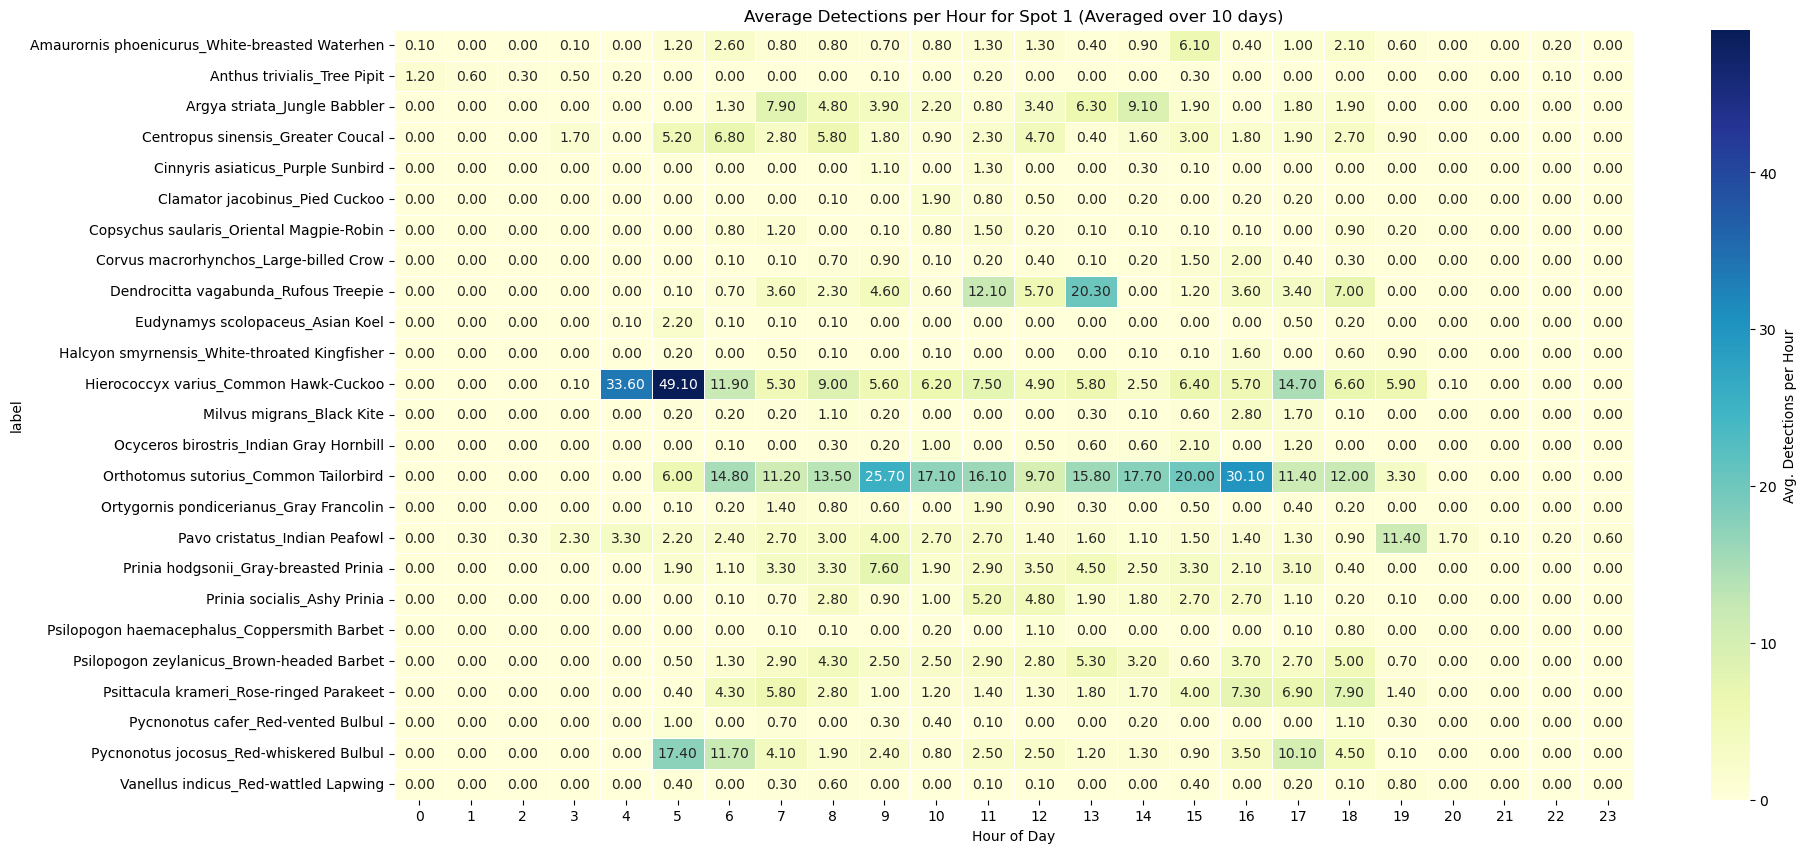

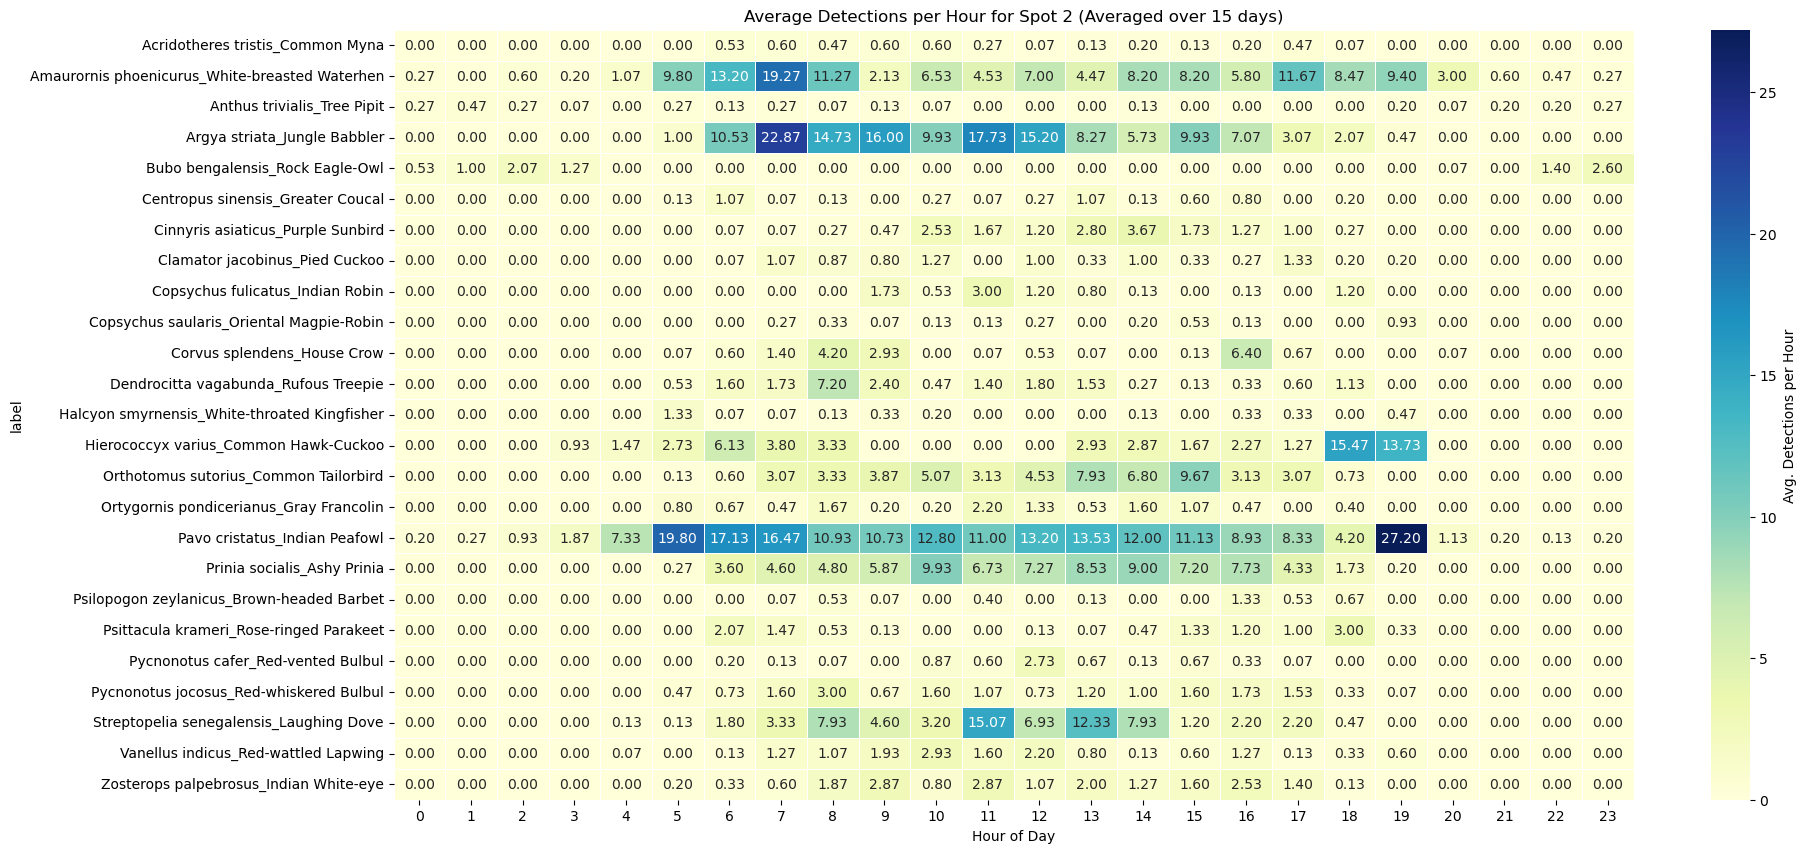

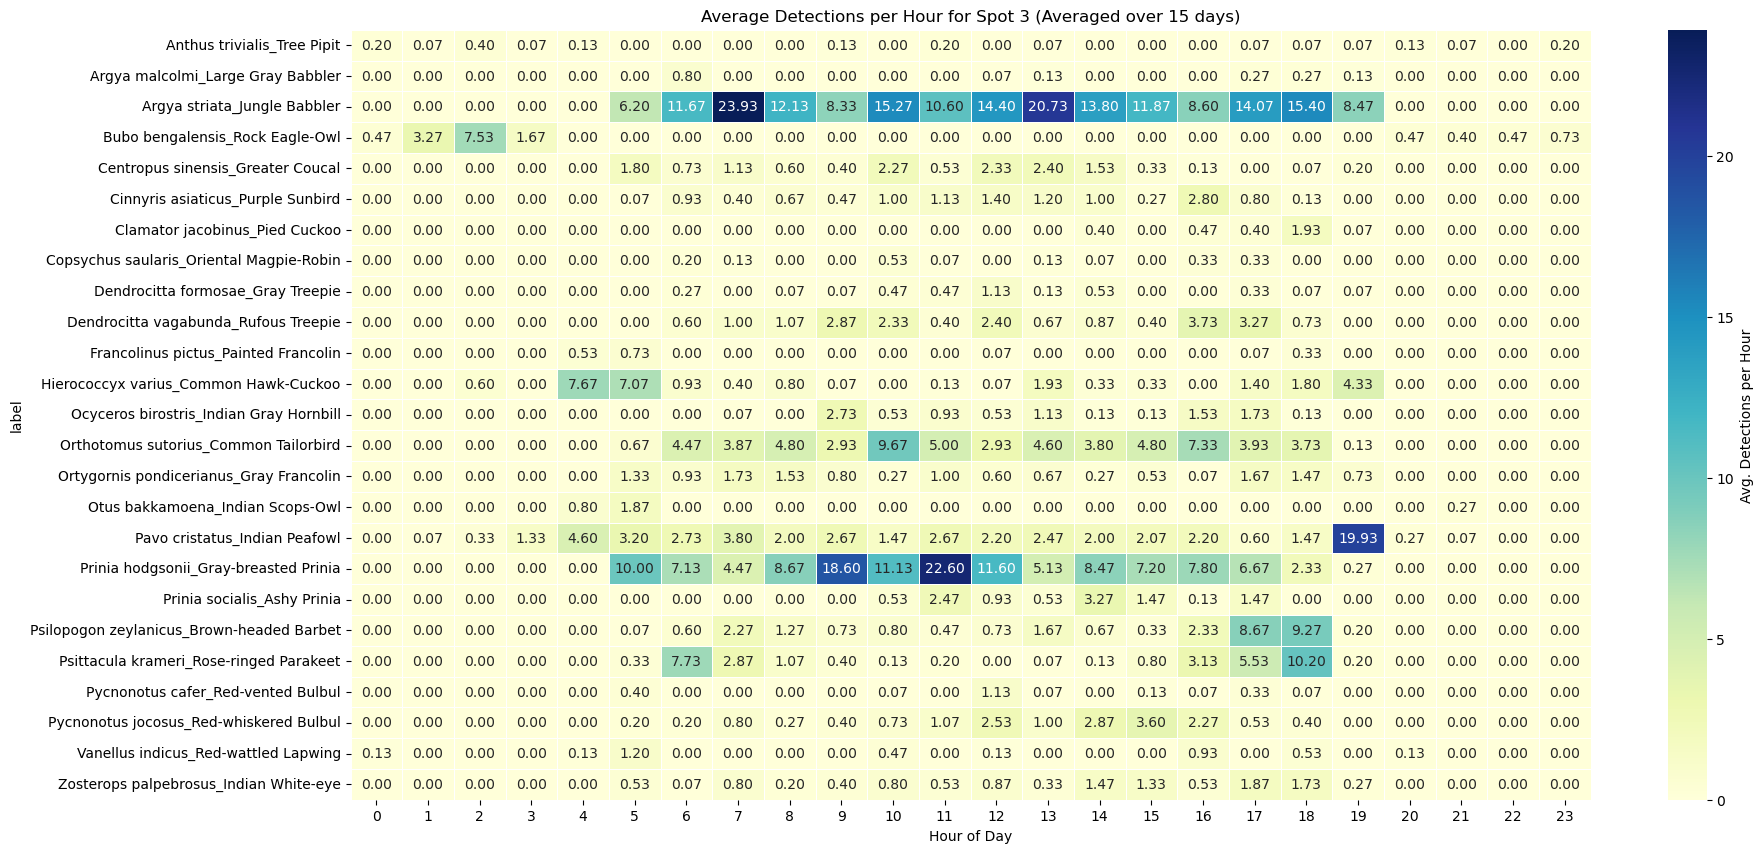

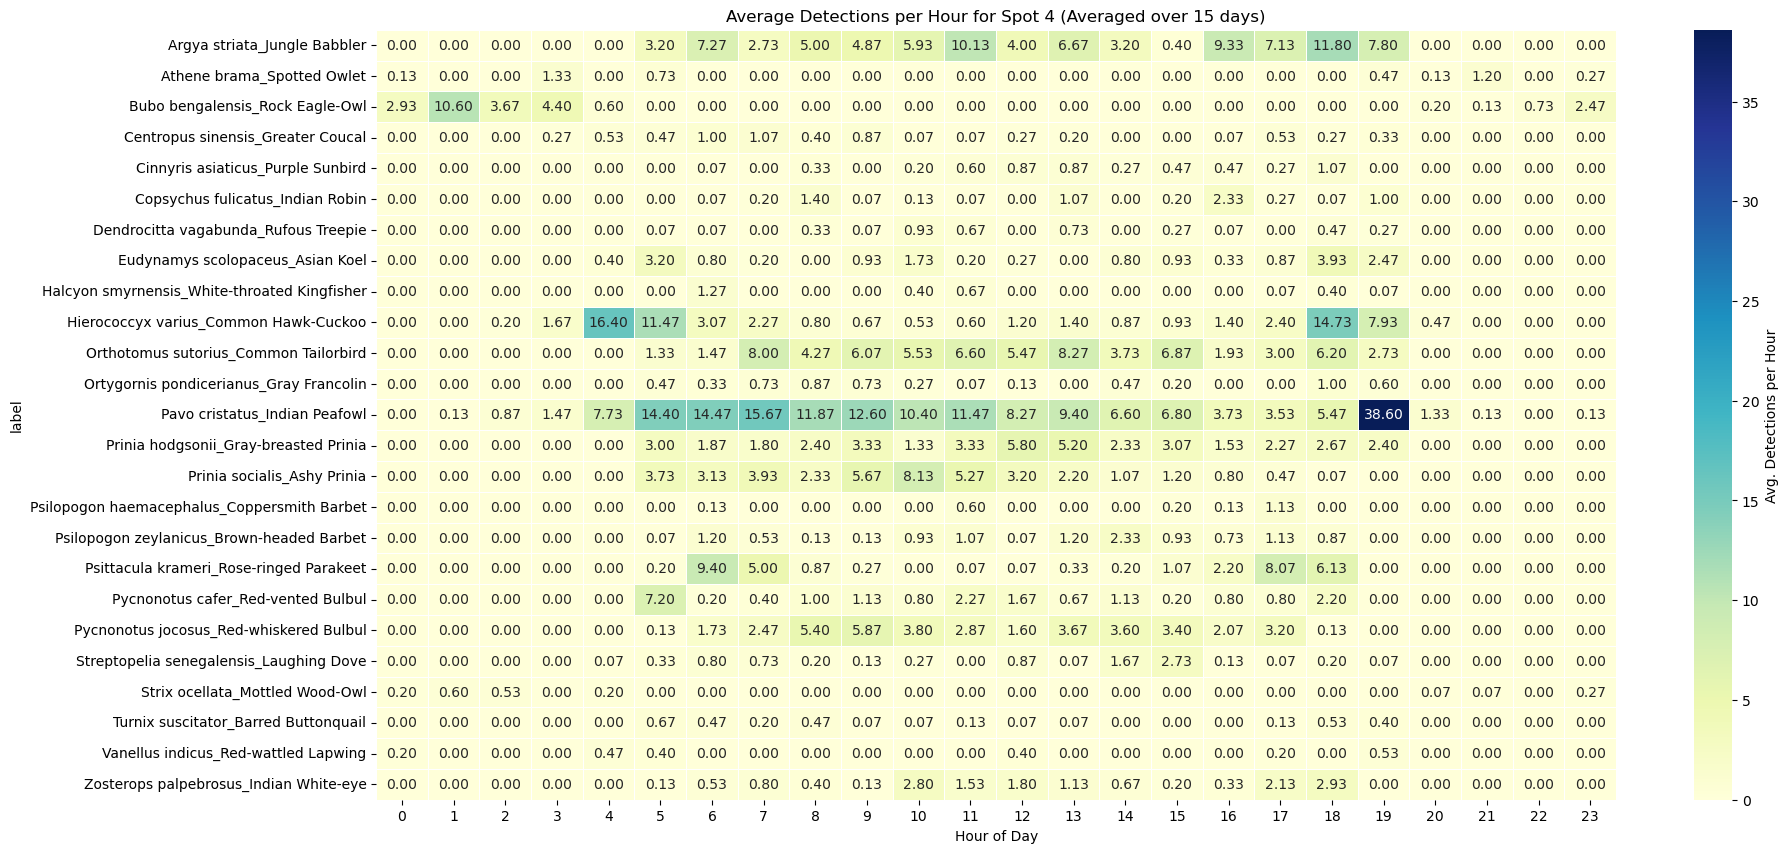

In [ ]:
#--- Non-Normalized Heat Maps ---
print("\nGenerating Non-Normalized Spot-wise Activity Heatmaps...")

activity_df = results_df[results_df['confidence'] >= 0.5].copy()
activity_df = activity_df[~activity_df['label'].str.contains("Engine|Siren", na=False)]

for spot in sorted(activity_df['Spot'].unique()):
    spot_df = activity_df[activity_df['Spot'] == spot]
    num_days = spot_df['Date'].nunique()
    if num_days == 0:
        continue

    top_species_in_spot = spot_df['label'].value_counts().nlargest(25).index
    spot_df_top = spot_df[spot_df['label'].isin(top_species_in_spot)]

    activity_pivot = spot_df_top.pivot_table(
        index='label', 
        columns='hour', 
        values='filename', 
        aggfunc='count',
        fill_value=0
    )
    
    average_activity_pivot = activity_pivot / num_days
    
    plt.figure(figsize=(20, 10))
    sns.heatmap(
        average_activity_pivot, 
        cmap="YlGnBu",
        linewidths=.5,
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Avg. Detections per Hour'}
    )
    
    plt.title(f"Average Detections per Hour for {spot.replace('_', ' ').title()} (Averaged over {num_days} days)")
    plt.xlabel("Hour of Day")
    plt.ylabel("label")
    plt.show()




Generating Spot-wise Activity Heatmaps...


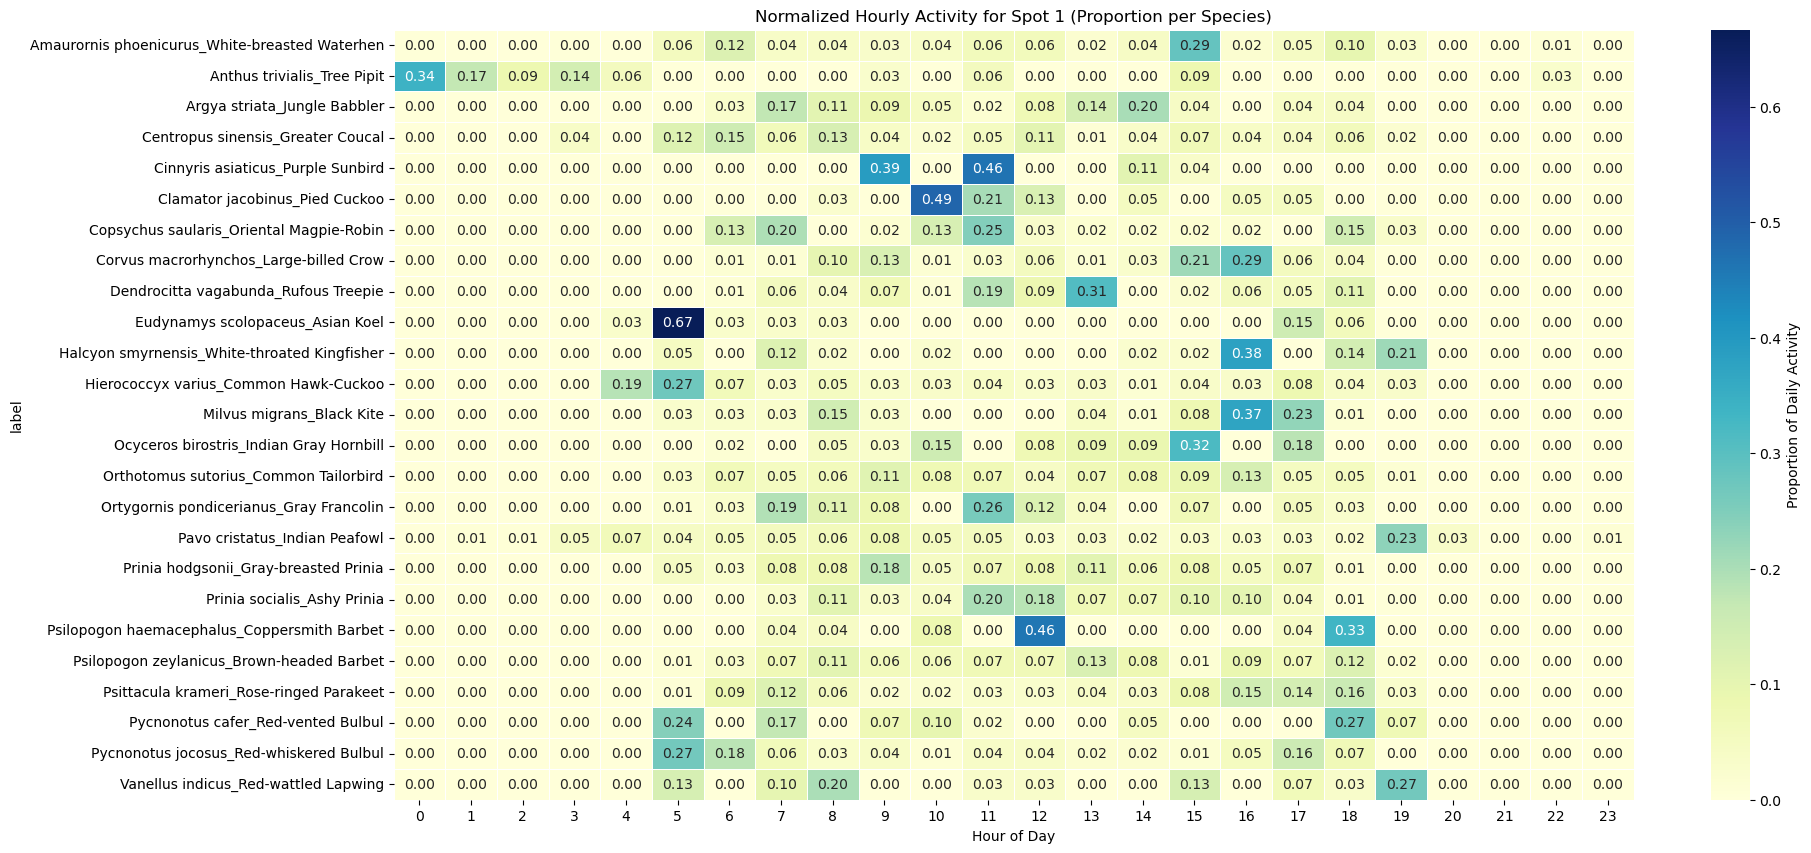

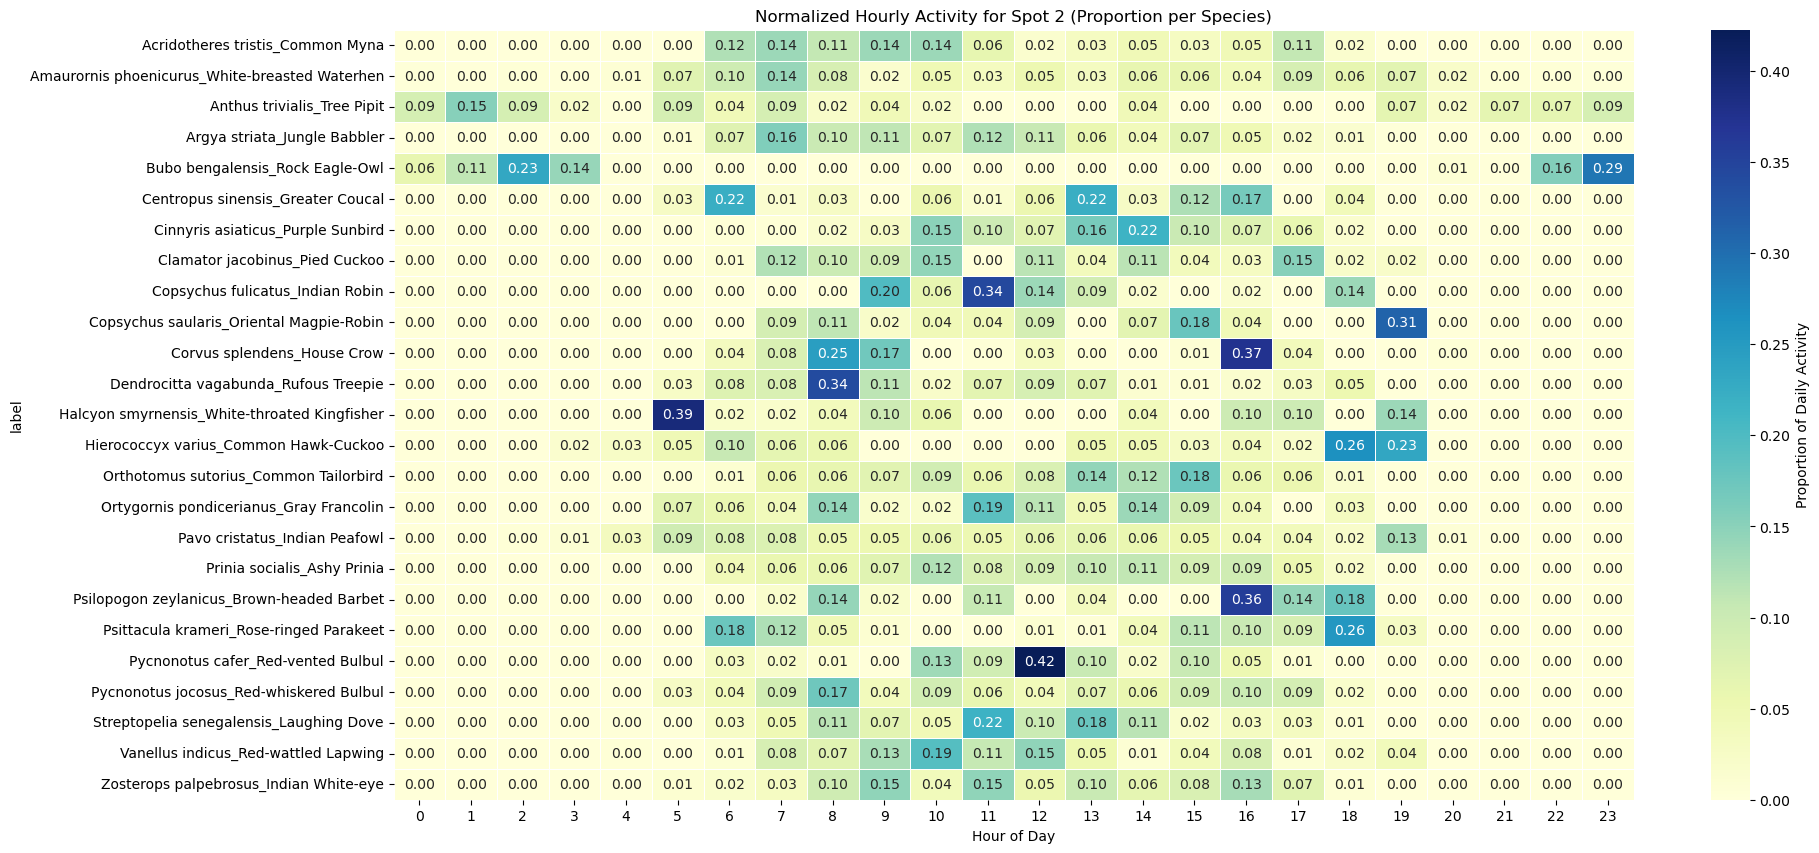

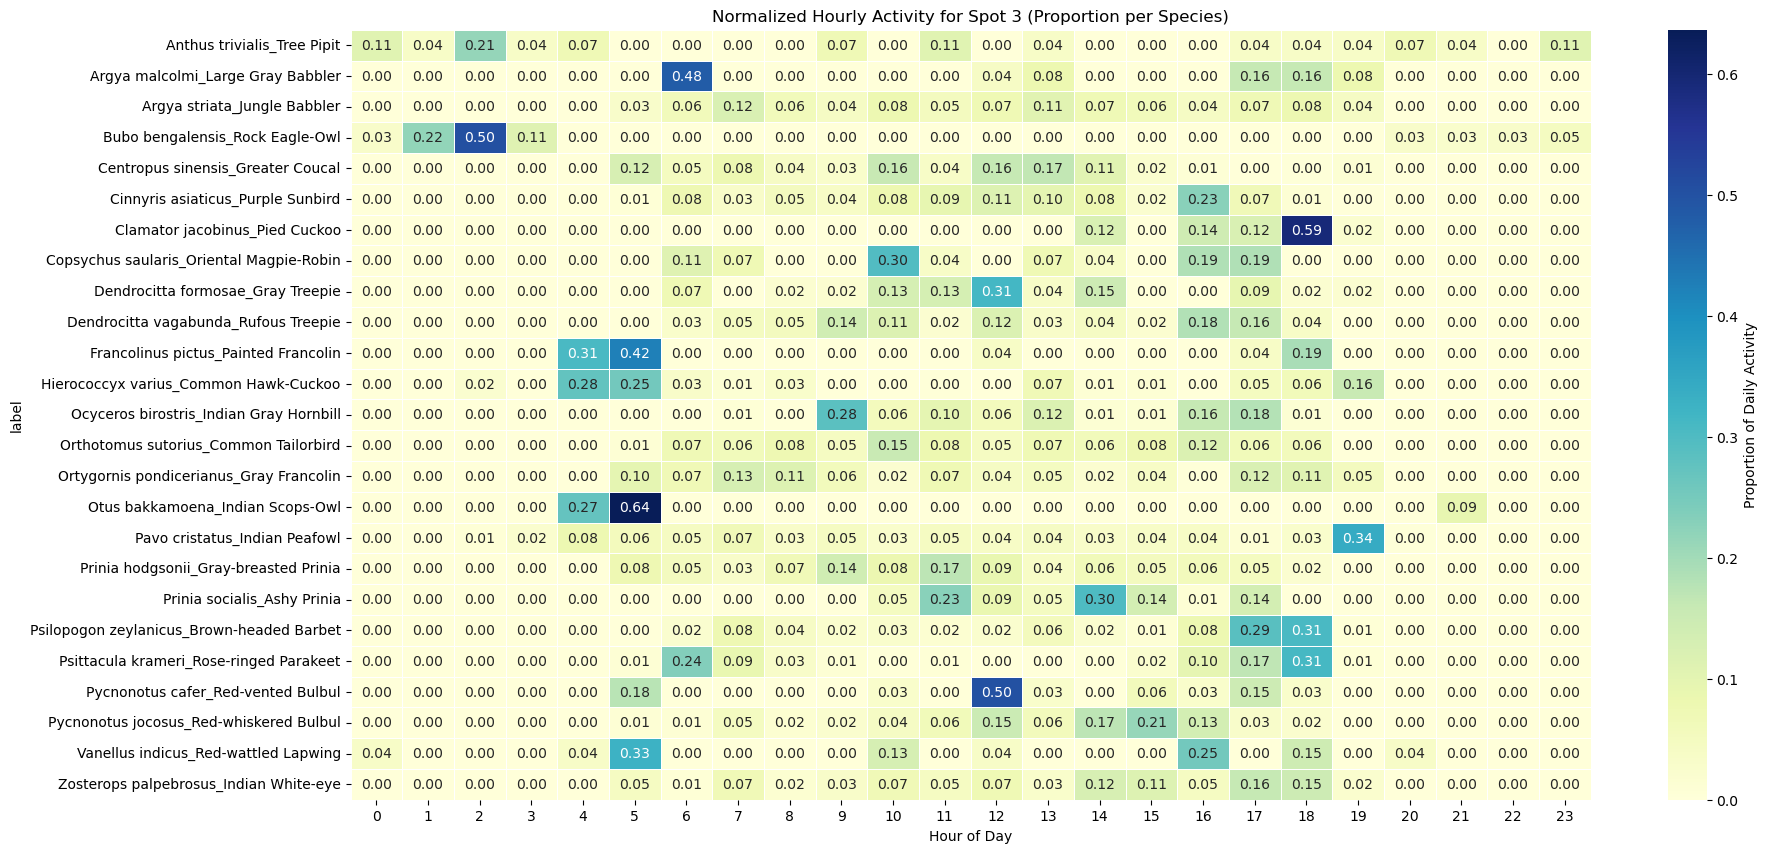

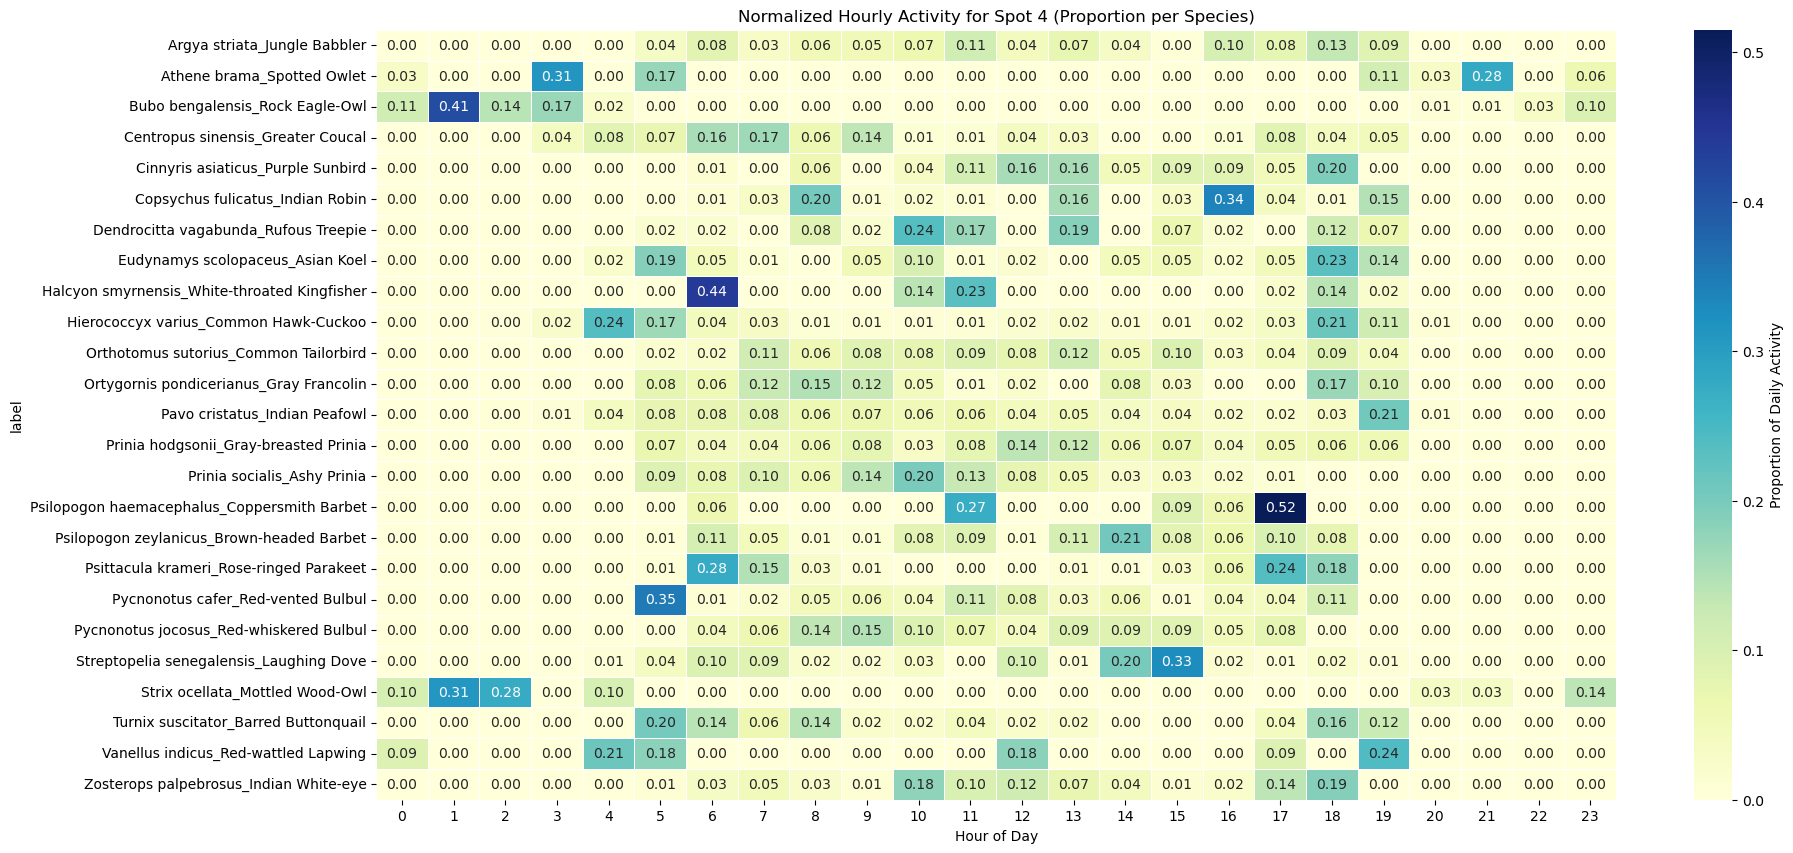

In [ ]:
#--- Normalized Heat Maps ---
print("\nGenerating Normalized  Spot-wise Activity Heatmaps...")

activity_df = results_df[results_df['confidence'] >= 0.5].copy()
activity_df = activity_df[~activity_df['label'].str.contains("Engine|Siren", na=False)]

for spot in sorted(activity_df['Spot'].unique()):
    spot_df = activity_df[activity_df['Spot'] == spot]
    num_days = spot_df['Date'].nunique()
    if num_days == 0:
        continue

    top_species_in_spot = spot_df['label'].value_counts().nlargest(25).index
    spot_df_top = spot_df[spot_df['label'].isin(top_species_in_spot)]

    activity_pivot = spot_df_top.pivot_table(
        index='label', 
        columns='hour', 
        values='filename', 
        aggfunc='count',
        fill_value=0
    )
    
    average_activity_pivot = activity_pivot / num_days
    
    # Row-wise normalization by sum
    average_activity_pivot_norm = average_activity_pivot.div(
        average_activity_pivot.sum(axis=1), axis=0
    )

    plt.figure(figsize=(20, 10))
    sns.heatmap(
        average_activity_pivot_norm, 
        cmap="YlGnBu",
        linewidths=.5,
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Proportion of Daily Activity'}
    )
    
    plt.title(f"Normalized Hourly Activity for {spot.replace('_', ' ').title()} (Proportion per Species)")
    plt.xlabel("Hour of Day")
    plt.ylabel("label")
    plt.show()


### Part 5: Acoustic & Biodiversity Index Analysis
This section first identifies the most effective acoustic indices by correlating them with a ground-truth biodiversity metric (Shannon Index). Then, it uses box plots to compare the distributions of these key indices across the different monitoring spots.

In [ ]:
INDEX_FILES = [r"E:\monitoring_data\sound_recordings\spot_1_original_spot\20072025-29072025_2R4W\results.csv", r"E:\monitoring_data\sound_recordings\spot_2_peacock_spot\20072025-03082025_2R4W\results.csv", r"E:\monitoring_data\sound_recordings\spot_4_yoga_spot\20072025-03082025_2R4W\results.csv", r"E:\monitoring_data\sound_recordings\spot_3_investigation_spot\20072025-03082025_2R4W\results.csv"]
SAVE = [] # paths to csv to save combined indices

In [ ]:
# --- Load and Preprocess Index Files ---
results_i_df = pd.DataFrame()
for i in INDEX_FILES:
    try:
        df = pd.read_csv(i)
        results_i_df = pd.concat([results_i_df, df], ignore_index=True)
    except FileNotFoundError:
        print(f"File {i} not found. Skipping...")
if 'filename' in df.columns:
    # If it exists, rename it to 'Filename'
    # The 'inplace=True' argument modifies the DataFrame directly.
    df.rename(columns={'filename': 'Filename'}, inplace=True)
    print("\nSuccessfully renamed 'filename' to 'Filename'.")
    


File E:\monitoring_data\sound_recordings\spot_1_original_spot\20072025-29072025_2R4W\results.csv not found. Skipping...
File E:\monitoring_data\sound_recordings\spot_2_peacock_spot\20072025-03082025_2R4W\results.csv not found. Skipping...
File E:\monitoring_data\sound_recordings\spot_4_yoga_spot\20072025-03082025_2R4W\results.csv not found. Skipping...
File E:\monitoring_data\sound_recordings\spot_3_investigation_spot\20072025-03082025_2R4W\results.csv not found. Skipping...


KeyError: 'filename'

In [ ]:
results_i_df['Spot'] = results_i_df['Filename'].str.extract(r'(SPOT\d+)', expand=False).str.lower().str.replace('spot', 'spot_')
date_info = results_i_df['Filename'].str.extract(r'_(\d{8})_')
results_i_df['Date'] = pd.to_datetime(date_info[0], format='%Y%m%d')
results_i_df.dropna(subset=['Spot'], inplace=True)

print("Preprocessing complete. 'Spot' and 'Date' columns added.")
print(f"Spots found: {sorted(results_i_df['Spot'].unique())}")
results_i_df.head()

In [ ]:
import pandas as pd
import numpy as np

# --- Helper Functions (ensure these are defined in your script) ---
def compute_shannon(labels):
    """Computes the Shannon diversity index from a series of labels."""
    counts = labels.value_counts()
    proportions = counts / len(labels)
    # Use np.log2 for the Shannon index calculation; add a small epsilon to avoid log(0)
    proportions = proportions[proportions > 0]
    shannon_index = -np.sum(proportions * np.log2(proportions))
    return shannon_index

def compute_simpson(labels):
    """Computes the Simpson diversity index from a series of labels."""
    counts = labels.value_counts()
    n = len(labels)
    if n < 2:
        return np.nan # Simpson's index is undefined for less than 2 individuals
    
    numerator = np.sum(counts * (counts - 1))
    denominator = n * (n - 1)
    
    # Simpson's Index (D) is numerator / denominator. We return 1 - D (Gini-Simpson index).
    simpson_index = 1 - (numerator / denominator)
    return simpson_index

# --- Configuration: Define your file paths here ---
# Assume OUTPUTS, INDEX_FILES, and SAVE are lists of file paths.
# Example lists for testing:
OUTPUTS = ['bird_detections.csv']
INDEX_FILES = ['acoustic_indices.csv']
SAVE = ['final_combined_indices.csv']

# --- Create dummy CSV files for a runnable example ---
# This part is just for demonstration. You would use your own files.
pd.DataFrame({
    'filename': ['audio1.wav', 'audio1.wav', 'audio2.wav', 'audio2.wav', 'audio2.wav', 'audio3.wav'],
    'confidence': [0.9, 0.8, 0.4, 0.7, 0.9, 0.95],
    'label': ['sparrow', 'robin', 'sparrow', 'finch', 'finch', 'sparrow'],
    'Spot': [1, 1, 2, 2, 2, 3],
    'Date': ['2023-10-26', '2023-10-26', '2023-10-27', '2023-10-27', '2023-10-27', '2023-10-28']
}).to_csv('bird_detections.csv', index=False)

pd.DataFrame({
    'Filename': ['audio1.wav', 'audio2.wav', 'audio4.wav'], # Note the capital 'F' and a non-matching file
    'ADI': [0.5, 0.6, 0.7], 'ACI': [1.2, 1.3, 1.4], 'AEI': [0.8, 0.9, 1.0],
    'NDSI': [0.1, 0.2, 0.3], 'MFC': [10, 11, 12], 'CLS': [2.5, 2.6, 2.7]
}).to_csv('acoustic_indices.csv', index=False)
# --- End of dummy file creation ---


# Main processing loop
for i in range(len(OUTPUTS)):
    print(f"--- Processing file set {i+1}: {OUTPUTS[i]} & {INDEX_FILES[i]} ---")
    combined_df = pd.DataFrame() # Initialize an empty DataFrame

    try:
        # 1. Load the two data files
        detections_df = pd.read_csv(OUTPUTS[i])
        acoustic_df = pd.read_csv(INDEX_FILES[i])

        # 2. **Crucial Step:** Standardize column names to prevent merge errors.
        # We rename 'Filename' (capital F) to 'filename' (lowercase f) if it exists.
        if 'Filename' in detections_df.columns:
            detections_df.rename(columns={'Filename': 'filename'}, inplace=True)
        if 'Filename' in acoustic_df.columns:
            acoustic_df.rename(columns={'Filename': 'filename'}, inplace=True)
        print("Standardized 'filename' column for merging.")

        # 3. Calculate Shannon and Simpson indices in a single operation
        print("Calculating Shannon and Simpson indices...")
        diversity_df = (
            detections_df[detections_df['confidence'] >= 0.5]
            .groupby('filename')
            .agg(
                Shannon=('label', compute_shannon),
                Simpson=('label', compute_simpson),
                Spot=('Spot', 'first'),
                Date=('Date', 'first')
            )
            .reset_index()
            .dropna(subset=['Shannon', 'Simpson'])
        )

        # 4. Aggregate acoustic indices (if they have multiple rows per file)
        print("Aggregating acoustic indices...")
        avg_acoustic_df = (
            acoustic_df.groupby('filename')
            .agg({
                'ADI': 'mean', 'ACI': 'mean', 'AEI': 'mean',
                'NDSI': 'mean', 'MFC': 'mean', 'CLS': 'mean'
            })
            .reset_index()
        )

        # 5. Perform the final merge
        print("Merging all computed data...")
        combined_df = pd.merge(
            diversity_df,      # Contains Shannon, Simpson, Spot, Date
            avg_acoustic_df,   # Contains all acoustic indices
            on='filename',     # The common column to join on
            how='inner'        # 'inner' ensures we only keep files present in BOTH dataframes
        )
        
        if combined_df.empty:
            print("\nWARNING: Merge resulted in an empty DataFrame. No matching 'filename' entries found.")
        else:
            print("\n✅ Successfully merged all indices.")
            print(combined_df.head())

    # 6. Improved error handling for clear feedback
    except FileNotFoundError as e:
        print(f"\n❌ ERROR: File not found. Please check your paths. Details: {e}")
    except KeyError as e:
        print(f"\n❌ ERROR: A required column was not found. Please check your CSV files for column: {e}")
    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

    # 7. Save the final DataFrame to a CSV file
    # This will save the merged data, or an empty file if an error occurred.
    combined_df.to_csv(SAVE[i], index=False)
    print(f"\nSaved results to {SAVE[i]}")


In [ ]:
# ******* if combined indices are available **********
#pick the combined indices for any spot
combined_indices_df = pd.read_csv(r"E:\processed_data\acoustic_biodiversity\analysis\audio_raw_spot_4_yoga_spot_20072025-03082025_2R4W_combined_indices.csv")

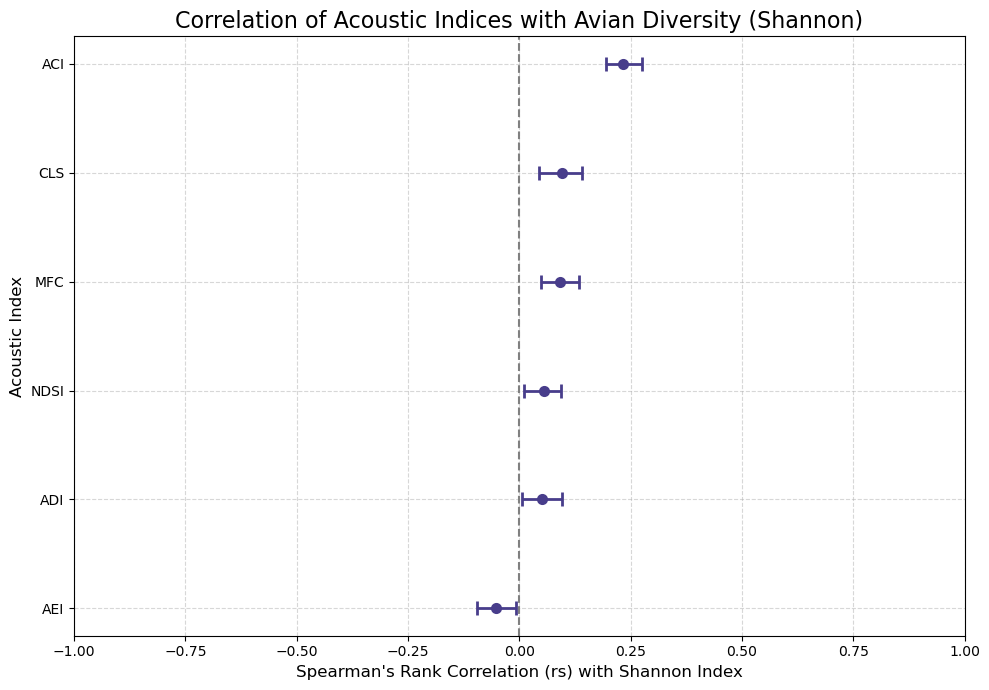

In [ ]:
# --- Identify Best Acoustic Indices via Correlation Plot with shannon ---
# This plot replicates the style from the research paper, showing which indices are most strongly
# correlated with avian biodiversity (Shannon Index).

def bootstrap_spearman(df, col_x, col_y, n_iterations=1000, random_seed=42):
    np.random.seed(random_seed)
    r_values = []
    for _ in range(n_iterations):
        sample = df.sample(frac=1, replace=True)
        r, _ = spearmanr(sample[col_x], sample[col_y])
        r_values.append(r)
    r_values = np.array(r_values)
    return np.mean(r_values), np.percentile(r_values, 2.5), np.percentile(r_values, 97.5)

if not combined_indices_df.empty:
    indices_to_test = ['ADI', 'ACI', 'AEI', 'NDSI', 'MFC', 'CLS']
    corr_results = []
    for index in indices_to_test:
        mean_r, ci_lower, ci_upper = bootstrap_spearman(combined_indices_df, index, 'Shannon')
        corr_results.append({'Index': index, 'Mean_r': mean_r, 'CI_lower': ci_lower, 'CI_upper': ci_upper})
    
    df_corr_results = pd.DataFrame(corr_results).sort_values('Mean_r')

    # Plotting the correlation graph
    plt.figure(figsize=(10, 7))
    plt.errorbar(df_corr_results['Mean_r'], df_corr_results['Index'],
                 xerr=[df_corr_results['Mean_r'] - df_corr_results['CI_lower'], 
                       df_corr_results['CI_upper'] - df_corr_results['Mean_r']],
                 fmt='o', color='darkslateblue', capsize=5, elinewidth=2, markeredgewidth=2)

    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel("Spearman's Rank Correlation (rs) with Shannon Index", fontsize=12)
    plt.ylabel("Acoustic Index", fontsize=12)
    plt.title("Correlation of Acoustic Indices with Avian Diversity (Shannon)", fontsize=16)
    plt.xlim(-1, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Step 5.2: Identify Best Acoustic Indices via Correlation Plot with simpson ---
# This plot replicates the style from the research paper, showing which indices are most strongly
# correlated with avian biodiversity (Simpson Index).

def bootstrap_spearman(df, col_x, col_y, n_iterations=1000, random_seed=42):
    np.random.seed(random_seed)
    r_values = []
    for _ in range(n_iterations):
        sample = df.sample(frac=1, replace=True)
        r, _ = spearmanr(sample[col_x], sample[col_y])
        r_values.append(r)
    r_values = np.array(r_values)
    return np.mean(r_values), np.percentile(r_values, 2.5), np.percentile(r_values, 97.5)

if not combined_indices_df.empty:
    indices_to_test = ['ADI', 'ACI', 'AEI', 'NDSI', 'MFC', 'CLS']
    corr_results = []
    for index in indices_to_test:
        mean_r, ci_lower, ci_upper = bootstrap_spearman(combined_indices_df, index, 'Simpson')
        corr_results.append({'Index': index, 'Mean_r': mean_r, 'CI_lower': ci_lower, 'CI_upper': ci_upper})
    
    df_corr_results = pd.DataFrame(corr_results).sort_values('Mean_r')

    # Plotting the correlation graph
    plt.figure(figsize=(10, 7))
    plt.errorbar(df_corr_results['Mean_r'], df_corr_results['Index'],
                 xerr=[df_corr_results['Mean_r'] - df_corr_results['CI_lower'], 
                       df_corr_results['CI_upper'] - df_corr_results['Mean_r']],
                 fmt='o', color='darkslateblue', capsize=5, elinewidth=2, markeredgewidth=2)

    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel("Spearman's Rank Correlation (rs) with Simpson Index", fontsize=12)
    plt.ylabel("Acoustic Index", fontsize=12)
    plt.title("Correlation of Acoustic Indices with Avian Diversity (Simpson)", fontsize=16)
    plt.xlim(-1, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

KeyError: 'Simpson'


Plotting box plots for the most effective indices...


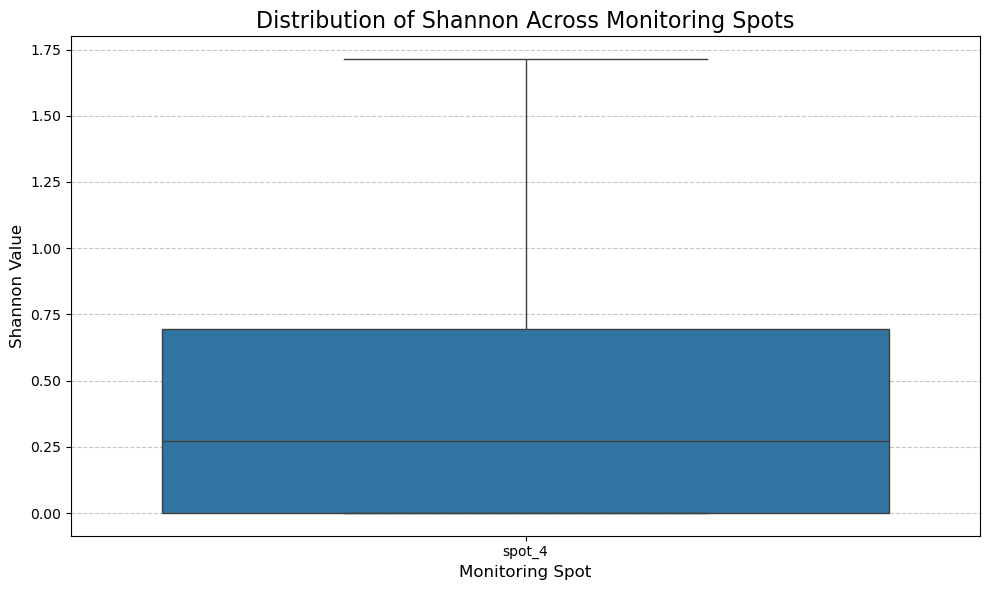

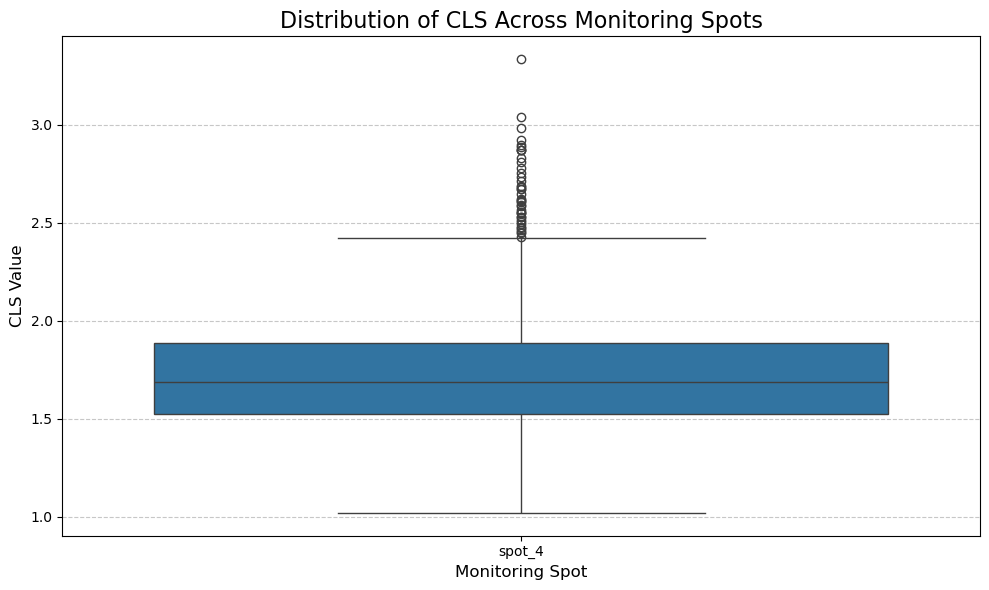

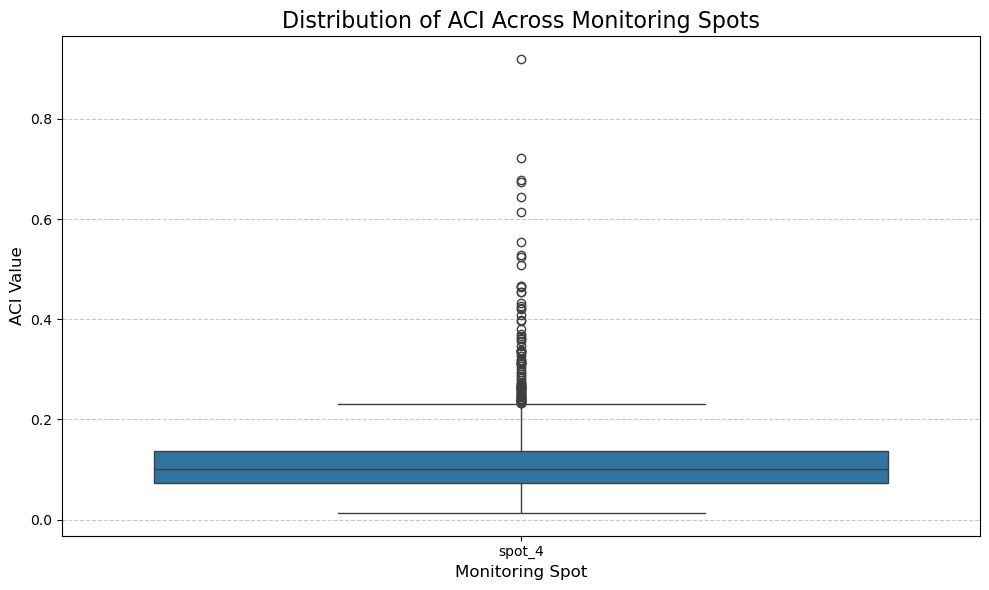

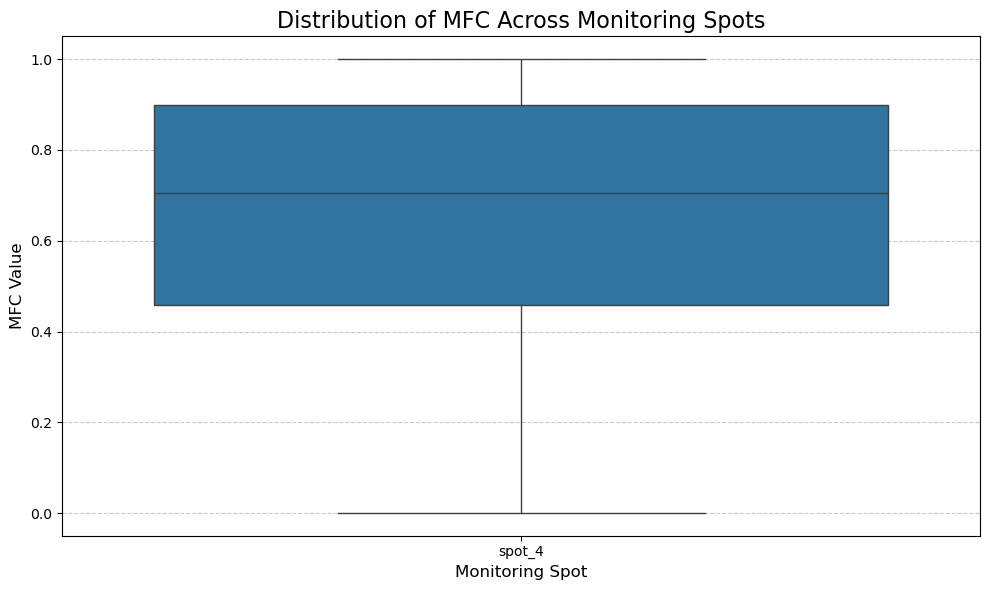

In [84]:
# --- Step 5.3: Plotting Comparative Box Plots ---
# Based on the correlation plot above, we select the most informative indices
# and compare their distributions across the different monitoring spots.

if not combined_indices_df.empty:
    # Select the indices with the highest positive correlations from the chart above, plus Shannon.
    plot_indices = ['Shannon', 'CLS', 'ACI', 'MFC'] 
    
    print("\nPlotting box plots for the most effective indices...")
    
    for index in plot_indices:
        if index in combined_indices_df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=combined_indices_df, x='Spot', y=index, order=sorted(combined_indices_df['Spot'].unique()))
            plt.title(f'Distribution of {index} Across Monitoring Spots', fontsize=16)
            plt.xlabel('Monitoring Spot', fontsize=12)
            plt.ylabel(f'{index} Value', fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

### Part 6: Regression Analysis
This section runs multiple types of regression to check prediction accuracy for Shannon's and Simpson's Index.
- **Multiple Linear Regression:** Uses all the indices to see if a linear regression can be fit, providing coefficients
- **Random Forest Regressor:** Applies a random forest model to capture non-linear relationships
- **Gradient Boost Regressor:** Uses the gradient boosting algorithm for potentially better performance on complex data


strong overlaps of code chunks with graphs.ipynb, data generated from there to be used here *

In [56]:
# --- Step 7.1: Multiple Linear Regression ---
# This model attempts to predict the Shannon Index using all available acoustic indices as features.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

if not combined_indices_df.empty:
    features = ['ADI', 'ACI', 'AEI', 'NDSI', 'MFC', 'CLS']
    model_df = combined_indices_df.dropna(subset=['Shannon'] + features)
    
    if len(model_df) > len(features):
        X = model_df[features].values
        y = model_df["Shannon"].values

        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X)
        r2 = r2_score(y, y_pred)

        print(f"Multiple Linear Regression using all indices to predict Shannon Index:")
        print(f"Model R² = {r2:.4f}")
        
        # Display coefficients to see feature importance
        coef_df = pd.DataFrame(reg.coef_, features, columns=['Coefficient'])
        print("\nFeature Coefficients:")
        print(coef_df)
    else:
        print("Not enough data for Linear Regression model.")

Multiple Linear Regression using all indices to predict Shannon Index:
Model R² = 0.0506

Feature Coefficients:
       Coefficient
ADI   1.617086e+05
ACI   3.387827e-01
AEI   1.009105e+06
NDSI -1.194089e-03
MFC  -4.786164e-01
CLS  -9.728502e-02


In [57]:
# In file: Graphs.ipynb
# Replace the Linear Regression cell (id="470513ce") with this

# --- Step 7.1: Advanced Modeling with Random Forest ---
# EXPLANATION: As the linear model showed, the relationship is not linear and the indices are correlated.
# A Random Forest model is much better suited for this type of data.

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

if not combined_indices_df.empty:
    # Select a more robust set of features, removing the redundant AEI
    features = ['ADI', 'ACI', 'NDSI', 'MFC', 'CLS']
    target = 'Shannon'
    
    model_df = combined_indices_df.dropna(subset=[target] + features)
    
    if len(model_df) > 10:
        X = model_df[features]
        y = model_df[target]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize and train the Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)

        # Evaluate the model
        y_pred_train = rf_model.predict(X_train)
        y_pred_test = rf_model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        print("Random Forest Regression to predict Shannon Index:")
        print(f"Train R² = {train_r2:.4f}")
        print(f"Test R²  = {test_r2:.4f}")

        # Display feature importances
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        print("\\nFeature Importances:")
        print(importance_df)
    else:
        print("Not enough data for Random Forest model.")

Random Forest Regression to predict Shannon Index:
Train R² = 0.8723
Test R²  = 0.0485
\nFeature Importances:
  Feature  Importance
3     MFC    0.249714
1     ACI    0.209957
0     ADI    0.191895
4     CLS    0.176103
2    NDSI    0.172330


In [87]:
# In file: Graphs.ipynb
# In the cell with id="replaced_shannon_cell" (Step 6.1)
# Replace the avg_indices_df calculation with this more detailed one.

try:
    # indices_df = pd.read_csv("newindices.csv")
    # indices_df.rename(columns={'Filename': 'filename'}, inplace=True)
    
    # --- FEATURE ENGINEERING: Create a richer set of features ---
    # Instead of just the mean, calculate multiple stats for each index per file.
    avg_indices_df = indices_df.groupby('filename').agg(
        ADI_mean=('ADI', 'mean'), ADI_std=('ADI', 'std'),
        ACI_mean=('ACI', 'mean'), ACI_std=('ACI', 'std'),
        AEI_mean=('AEI', 'mean'), AEI_std=('AEI', 'std'),
        NDSI_mean=('NDSI', 'mean'), NDSI_std=('NDSI', 'std'),
        MFC_mean=('MFC', 'mean'), MFC_std=('MFC', 'std'),
        CLS_mean=('CLS', 'mean'), CLS_std=('CLS', 'std')
    ).reset_index()
    
    # Fill any potential NaN values that result from std dev of a single segment
    avg_indices_df.fillna(0, inplace=True)

    combined_indices_df = pd.merge(shannon_df, avg_indices_df, on='filename', how='inner')
    print("Successfully merged Shannon and ENHANCED Acoustic Indices.")
    display(combined_indices_df.head())

except FileNotFoundError:
    print("\\nWARNING: 'newindices.csv' not found. Analysis cannot proceed.")
    combined_indices_df = pd.DataFrame()

Successfully merged Shannon and ENHANCED Acoustic Indices.


filename   Shannon    Spot  ADI_mean  ADI_std  \
0  076YOGASPOT4_20250720_083600.wav  1.039721  spot_4  5.029376      0.0   
1  076YOGASPOT4_20250720_084200.wav  1.098612  spot_4  6.066623      0.0   
2  076YOGASPOT4_20250720_084800.wav  1.011404  spot_4  4.877932      0.0   
3  076YOGASPOT4_20250720_090000.wav  0.000000  spot_4  5.754641      0.0   
4  076YOGASPOT4_20250720_090600.wav  0.000000  spot_4  5.033226      0.0   

   ACI_mean  ACI_std  AEI_mean  AEI_std  NDSI_mean  NDSI_std  MFC_mean  \
0  0.144302      0.0  0.194046      0.0  -0.541605       0.0  0.550538   
1  0.076963      0.0  0.027828      0.0   0.527707       0.0  0.952885   
2  0.110830      0.0  0.218315      0.0  -0.720411       0.0  0.515068   
3  0.092731      0.0  0.077823      0.0  -0.299363       0.0  0.796782   
4  0.096584      0.0  0.193429      0.0  -0.722446       0.0  0.560761   

   MFC_std  CLS_mean  CLS_std  
0      0.0  1.799093      0.0  
1      0.0  2.555961      0.0  
2      0.0  1.953685      0.0  
3      0.0  2.289181      0.0  
4      0.0  2.051382      0.0

In [89]:
# In file: Graphs.ipynb
# In the Random Forest cell (the last code cell)

if not combined_indices_df.empty:
    # Use the new, richer feature set
    features = [
        'ADI_mean', 'ADI_std', 'ACI_mean', 'ACI_std', 
        'AEI_mean', 'AEI_std', 'NDSI_mean', 'NDSI_std',
        'MFC_mean', 'MFC_std', 'CLS_mean', 'CLS_std'
    ]
    target = 'Shannon'
    
    # ... rest of the model training code remains the same ...
    model_df = combined_indices_df.dropna(subset=[target] + features)
    
    if len(model_df) > 10:
        X = model_df[features]
        y = model_df[target]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize and train the Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)

        # Evaluate the model
        y_pred_train = rf_model.predict(X_train)
        y_pred_test = rf_model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        print("Random Forest Regression to predict Shannon Index:")
        print(f"Train R² = {train_r2:.4f}")
        print(f"Test R²  = {test_r2:.4f}")

        # Display feature importances
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        print("\\nFeature Importances:")
        print(importance_df)
    else:
        print("Not enough data for Random Forest model.")
        

Random Forest Regression to predict Shannon Index:
Train R² = 0.8674
Test R²  = 0.0674
\nFeature Importances:
      Feature  Importance
2    ACI_mean    0.253160
6   NDSI_mean    0.202508
10   CLS_mean    0.185519
8    MFC_mean    0.164206
4    AEI_mean    0.102214
0    ADI_mean    0.092394
3     ACI_std    0.000000
1     ADI_std    0.000000
7    NDSI_std    0.000000
5     AEI_std    0.000000
9     MFC_std    0.000000
11    CLS_std    0.000000


In [90]:
# In file: Graphs.ipynb
# Replace the final Random Forest cell with this complete block

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

if not combined_indices_df.empty:
    # Use the enhanced feature set from Strategy 1
    features = [
        'ADI_mean', 'ADI_std', 'ACI_mean', 'ACI_std', 
        'AEI_mean', 'AEI_std', 'NDSI_mean', 'NDSI_std',
        'MFC_mean', 'MFC_std', 'CLS_mean', 'CLS_std'
    ]
    target = 'Shannon'
    
    model_df = combined_indices_df.dropna(subset=[target] + features)
    
    if len(model_df) > 20: # Need enough data for grid search
        X = model_df[features]
        y = model_df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # --- Hyperparameter Tuning with GridSearchCV ---
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None], # Controls tree depth to prevent overfitting
            'min_samples_leaf': [3, 5, 10],   # Prevents model from fitting to noise
            'max_features': ['sqrt', 'log2']  # Introduces more randomness
        }

        rf = RandomForestRegressor(random_state=42, n_jobs=-1)
        
        # Grid search will find the best combination of parameters using cross-validation
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, 
                                   scoring='r2', n_jobs=-1, verbose=1)
        
        print("Running GridSearchCV to find the best model parameters...")
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters found: {grid_search.best_params_}")
        
        best_model = grid_search.best_estimator_

        # Evaluate the BEST model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        print("\\nOptimized Random Forest Regression Results:")
        print(f"Train R² = {train_r2:.4f}")
        print(f"Test R²  = {test_r2:.4f}")

        # Display feature importances from the best model
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': best_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        print("\\nFeature Importances:")
        print(importance_df)
    else:
        print("Not enough data for robust model training and tuning.")

Running GridSearchCV to find the best model parameters...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 200}
\nOptimized Random Forest Regression Results:
Train R² = 0.3142
Test R²  = 0.0755
\nFeature Importances:
      Feature  Importance
2    ACI_mean    0.303319
6   NDSI_mean    0.155504
8    MFC_mean    0.147852
10   CLS_mean    0.137950
0    ADI_mean    0.130433
4    AEI_mean    0.124941
3     ACI_std    0.000000
1     ADI_std    0.000000
7    NDSI_std    0.000000
5     AEI_std    0.000000
9     MFC_std    0.000000
11    CLS_std    0.000000


In [92]:
# Example of swapping the model
from sklearn.ensemble import GradientBoostingRegressor


# In file: Graphs.ipynb
# Replace the final Random Forest cell with this complete block

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

if not combined_indices_df.empty:

    
    # Use the enhanced feature set from Strategy 1
    features = [
        'ADI_mean', 'ADI_std', 'ACI_mean', 'ACI_std', 
        'AEI_mean', 'AEI_std', 'NDSI_mean', 'NDSI_std',
        'MFC_mean', 'MFC_std', 'CLS_mean', 'CLS_std'
    ]
    target = 'Shannon'
    
    model_df = combined_indices_df.dropna(subset=[target] + features)
    
    if len(model_df) > 20: # Need enough data for grid search
        X = model_df[features]
        y = model_df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # --- Hyperparameter Tuning with GridSearchCV ---
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None], # Controls tree depth to prevent overfitting
            'min_samples_leaf': [3, 5, 10],   # Prevents model from fitting to noise
            'max_features': ['sqrt', 'log2']  # Introduces more randomness
        }


        gb_model = GradientBoostingRegressor(random_state=42)
        param_grid_gb = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
        grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='r2', n_jobs=-1)

        
        print("Running GridSearchCV to find the best model parameters...")
        grid_search_gb.fit(X_train, y_train)
        
        print(f"Best parameters found: {grid_search_gb.best_params_}")
        
        best_model = grid_search_gb.best_estimator_

        # Evaluate the BEST model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        print("\\nOptimized Random Forest Regression Results:")
        print(f"Train R² = {train_r2:.4f}")
        print(f"Test R²  = {test_r2:.4f}")

        # Display feature importances from the best model
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': best_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        print("\\nFeature Importances:")
        print(importance_df)
    else:
        print("Not enough data for robust model training and tuning.")

# ... (inside the if not combined_indices_df.empty block) ...

# ... etc.

Running GridSearchCV to find the best model parameters...
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
\nOptimized Random Forest Regression Results:
Train R² = 0.2386
Test R²  = 0.0641
\nFeature Importances:
      Feature  Importance
2    ACI_mean    0.417627
6   NDSI_mean    0.159321
8    MFC_mean    0.144677
10   CLS_mean    0.117885
0    ADI_mean    0.090290
4    AEI_mean    0.070201
3     ACI_std    0.000000
1     ADI_std    0.000000
7    NDSI_std    0.000000
5     AEI_std    0.000000
9     MFC_std    0.000000
11    CLS_std    0.000000
